In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  8 00:01:10 2018

@author: mimbres

NOTE: In advance of using this code, plaease run "preparing_data.py" once.
"""
import numpy as np
from torch.utils.data.dataset import Dataset
#from torch.utils.data import DataLoader <--이게 문제가있다고함
from torch.utils.data.dataloader import DataLoader
from utils.save_load_config import load_config
from utils.matrix_math import indices_to_one_hot


# TRSET stats: 2072002577 items within 124950714 sessions
# TSSET stats: 518260758 items within 31251398 sessions

def SpotifyDataloader(config_fpath="./config_init_dataset.json",
                      mtrain_mode=True,
                      random_track_order=False,
                      data_sel=None,
                      seq_mode=False,
                      batch_size=1,
                      shuffle=False,
                      num_workers=4,
                      pin_memory=True):
    
    dset = SpotifyDataset(config_fpath=config_fpath,
                                mtrain_mode=mtrain_mode,
                                random_track_order=random_track_order,
                                data_sel=data_sel,
                                seq_mode=seq_mode)
    dloader = DataLoader(dset,
                         batch_size=batch_size,
                         shuffle=shuffle,
                         num_workers=num_workers,
                         pin_memory=pin_memory)
    return dloader
     


class SpotifyDataset(Dataset):
    '''
    mtrain_mode : (bool) True for meta-train(default) / False for meta-test
    random_track_order !! NOT IMPLEMENTED YET !!: (bool) True for non-sequential / False for sequential(default) 
    data_sel: list(start_idx, end_idx) selection of sessions for using only partial data, None(default) uses all.
    
    NOTE: __getitem__() always keeps the output session length as 20. To do so, 
          it can add dummy rows filled with zeros. 
    '''
    def __init__(self,
                 config_fpath="./config_init_dataset.json",
                 mtrain_mode=True,
                 random_track_order=False, 
                 data_sel=None,
                 seq_mode=False):
        
        config = load_config(config_fpath)
        TRACK_FEAT_NPY_PATH       = config.output_data_root + "track_feat.npy"
        TR_LOG_MEMMAP_DAT_PATH    = config.output_data_root + "tr_log_memmap.dat"
        TR_SESSION_SPLIT_IDX_PATH = config.output_data_root + "tr_session_split_idx.npy"
        TR_LOG_DATA_SHAPE = (2072002577, 23) # Hint: How to know the shape of new data? --> open memmap.data file and divide 1D shape by 23!
        TS_LOG_MEMMAP_DAT_PATH    = config.output_data_root + "ts_log_memmap.dat"
        TS_SESSION_SPLIT_IDX_PATH = config.output_data_root + "ts_session_split_idx.npy"
        TS_LOG_DATA_SHAPE = (518260758, 23)
        
        self.mtrain_mode           = mtrain_mode
        self.random_track_order    = random_track_order
        self.data_sel              = data_sel
        self.seq_mode              = seq_mode
        self.session_start_end_idx = []
        self.dt_mm                 = []
        self.track_feat            = []
        
        if self.mtrain_mode:
            fpath_log_mm_dat   = TR_LOG_MEMMAP_DAT_PATH
            fpath_sess_spl_idx = TR_SESSION_SPLIT_IDX_PATH
            log_data_shape     = TR_LOG_DATA_SHAPE
        else:
            fpath_log_mm_dat   = TS_LOG_MEMMAP_DAT_PATH
            fpath_sess_spl_idx = TS_SESSION_SPLIT_IDX_PATH
            log_data_shape     = TS_LOG_DATA_SHAPE
        
        # Import session log data: 'dt_mm' 
        self.dt_mm = np.memmap(fpath_log_mm_dat, dtype='uint8', mode='r', shape=log_data_shape)
        
        
        # Prepare 'session_start_end_idx' from 'session_split_indices'
        _sess_split = np.load(fpath_sess_spl_idx, allow_pickle=True) # shape=(index,)   
        self.session_start_end_idx = np.empty(shape=(len(_sess_split), 2), dtype=np.uint32)
        self.session_start_end_idx[:,0]   = _sess_split        
        self.session_start_end_idx[:,1] = np.r_[_sess_split[1:], len(self.dt_mm)-1]
        if self.data_sel is not None:
            self.session_start_end_idx = self.session_start_end_idx[range(data_sel[0], data_sel[1]),:]
        
        # Prepare 'track_feat' 
        self.track_feat = np.load(TRACK_FEAT_NPY_PATH, allow_pickle=True) 
        return None
    
    
    
    def __getitem__(self, index): 
        # 'num_items': the number of items(~=tracks) in one session
        _num_sup = np.floor((self.session_start_end_idx[index,1] - self.session_start_end_idx[index,0])/2).astype(int)
        _num_que = np.ceil((self.session_start_end_idx[index,1] - self.session_start_end_idx[index,0])/2).astype(int)
        num_items = np.array([_num_sup, _num_que], dtype=np.int32)  


            
        if self.seq_mode is False:
            # session_log
            session_log_sup = self.dt_mm[np.arange(self.session_start_end_idx[index,0],
                                               self.session_start_end_idx[index,0]+_num_sup), :]
            session_log_que = self.dt_mm[np.arange(self.session_start_end_idx[index,0]+_num_sup,
                                                   self.session_start_end_idx[index,1]), :]
            # Unpack track_id and dates (packed as 4 uint8, each):
            track_ids_sup = np.ascontiguousarray(session_log_sup[:, :4]).view(np.uint32).flatten() # dim[0,1,2,3] for track_id
            track_ids_que = np.ascontiguousarray(session_log_que[:, :4]).view(np.uint32).flatten()
            #dates     = np.ascontiguousarray(session_log[:, 4:8]).view(np.uint32).flatten() # dim[4,5,6,7] for date.   
                # date는 일단 안씀.., 
            # NOTE: We always keep the session length of output feature as 20, and several last items are dummys filled with 0s.
            # DIMs: feats(dim=29) = track_feat(dim=29), logs(dim=41) = log_feat(dim=41), 
            feats_sup = np.zeros(shape=(10, 29), dtype=np.float32)
            feats_que = np.zeros(shape=(10, 29), dtype=np.float32)
            logs_sup  = np.zeros(shape=(10, 41), dtype=np.float32)
            logs_que  = np.zeros(shape=(10, 41), dtype=np.float32)
            labels_sup = np.zeros(shape=(10, 3), dtype=np.float32)
            labels_que = np.zeros(shape=(10, 3), dtype=np.float32)
            
            # Fill out the feats dimensions as:
            # [0,..28] : track features 
            feats_sup[:_num_sup, :]  = self.track_feat[track_ids_sup, :]
            feats_que[:_num_que, :]  = self.track_feat[track_ids_que, :]

            # Fill out the logs dimensions as:
            # [0]       : minmax-scaled date in the range of -1 to 1
            # [1,...8] : n_seekfwd, n_seekback, skip_1,2,3, hist_sh, ct_swc, no_p, s_p, l_p, premium
            # [9,..40] : one-hot-encoded categorical labels of context_type, bh_start, bh_end 
            logs_sup[:_num_sup, 0] = (session_log_sup[:, 8].astype(np.float32)/24)+0.042# 시간: 0.042~1로 normalize..(session_log_sup[:, 8] / 23) * 2 - 1
            logs_sup[:_num_que, 0] = (session_log_que[:, 8].astype(np.float32)/24)+0.042
            logs_sup[:_num_sup, 1] = np.log(session_log_sup[:, 9].astype(np.float32)+2) / np.log(255+2)  # n_seekfwd: Normalized to 0.125~1 in log-scale
            logs_que[:_num_que, 1] = np.log(session_log_que[:, 10].astype(np.float32)+2) / np.log(255+2) # n_seekback: Normalized to 0.125~1 in log-scale
            logs_sup[:_num_sup, 2] = session_log_sup[:, 10]
            logs_que[:_num_que, 2] = session_log_que[:, 10]
            logs_sup[:_num_sup, 3:9] = session_log_sup[:, [14,15,16,17,18,19]]
            logs_que[:_num_que, 3:9] = session_log_que[:, [14,15,16,17,18,19]]
            logs_sup[:_num_sup, 9:15] = indices_to_one_hot(data=session_log_sup[:,20], nb_classes=6)
            logs_que[:_num_que, 9:15] = indices_to_one_hot(data=session_log_que[:,20], nb_classes=6)
            logs_sup[:_num_sup, 15:28] = indices_to_one_hot(data=session_log_sup[:,21], nb_classes=13)
            logs_que[:_num_que, 15:28] = indices_to_one_hot(data=session_log_que[:,21], nb_classes=13)
            logs_sup[:_num_sup, 28:41] = indices_to_one_hot(data=session_log_sup[:,22], nb_classes=13) 
            logs_que[:_num_que, 28:41] = indices_to_one_hot(data=session_log_que[:,22], nb_classes=13)
            
            labels_sup[:_num_sup, :] = session_log_sup[:, [11,12,13]] 
            labels_que[:_num_que, :] = session_log_que[:, [11,12,13]] 
            return feats_sup, feats_que, logs_sup, logs_que, labels_sup, labels_que, num_items, index
        else: # for Seq Mode...
            
            session_log = self.dt_mm[np.arange(self.session_start_end_idx[index,0],
                                               self.session_start_end_idx[index,1]), :]	
            
    # Unpack track_id and dates (packed as 4 uint8, each):
            track_ids = np.ascontiguousarray(session_log[:, :4]).view(np.uint32).flatten() # dim[0,1,2,3] for track_id
            dates     = np.ascontiguousarray(session_log[:, 4:8]).view(np.uint32).flatten() # dim[4,5,6,7] for date. 
            # date는 일단 안씀.., 
            
            # NOTE: Here we always keep the session length of the output feature as 20, and the first 10 items 
            #       are supports with left padded 0s. The last 10 items are queries with right padded 0s.
            ## DIMs: feats(dim=70) = [log_feat(dim=41), track_feat(dim=29)]
            feats  = np.zeros(shape=(20, 71), dtype=np.float32)
            labels = np.zeros(shape=(20,), dtype=np.float32)
            y_mask = np.zeros((20,), dtype=np.float32)
            # Fill out the feature dimensions as:
            # [0]       : minmax-scaled hour in the range of 0.042 ~ 1.0
            # [1,...8] : n_seekfwd, n_seekback, skip_1,2,3, hist_sh, ct_swc, no_p, s_p, l_p, premium
            # [9,..40] : one-hot-encoded categorical labels of context_type, bh_start, bh_end 
            # [41,..69] : track features
            lzs = int(10 - _num_sup) # number of left zeros for padding             
            n_item = np.sum(num_items)
            feats[lzs:lzs+n_item, 0]   = session_log[:, 8]# 시간: 0.042~1로 normalize..(session_log[:, 8] / 23) * 2 - 1
            feats[lzs:lzs+n_item, 1]   = np.log(session_log[:, 9].astype(np.float32)+2) / np.log(255+2)  # n_seekfwd: Normalized to 0.125~1 in log-scale
            feats[lzs:lzs+n_item, 2]   = np.log(session_log[:, 10].astype(np.float32)+2) / np.log(255+2) # n_seekback: Normalized to 0.125~1 in log-scale
            feats[lzs:lzs+n_item, 3:9]   = session_log[:, [14,15,16,17,18,19]]
            feats[lzs:lzs+n_item, 9:15]  = indices_to_one_hot(data=session_log[:,20], nb_classes=6)
            feats[lzs:lzs+n_item, 15:28] = indices_to_one_hot(data=session_log[:,21], nb_classes=13)
            feats[lzs:lzs+n_item, 28:41] = indices_to_one_hot(data=session_log[:,22], nb_classes=13) 
            feats[lzs:lzs+n_item, 41] = dates
            feats[lzs:lzs+n_item, 42:]   = self.track_feat[track_ids, :]
            labels[lzs:lzs+n_item]    = session_log[:, 12].flatten()             

            y_mask[lzs:lzs+n_item] = 1
            return feats, labels, y_mask, num_items, index 
    

    def __len__(self):
        return len(self.session_start_end_idx) # return the number of sessions that we have
    
    
    def plot_bar(self, a, b, title):
        import matplotlib.pyplot as plt
        plt.bar(a,b)
        plt.ylabel('play count')
        plt.title(title)
        return

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.backends import cudnn
import numpy as np
import glob, os
import argparse
from tqdm import trange, tqdm 
from utils.eval import evaluate
from blocks.highway_dil_conv import HighwayDCBlock
cudnn.benchmark = True

config = "./config_init_dataset.json"
save_path = "./save/exp_seq1HL/"
load_continue_latest = None
use_suplog_as_feat = True
use_predicted_label = False
use_glu = False
class_num = 2
epochs = 30
learning_rate = 0.001
train_batch_size = 2048
test_batch_size = 1024
gpu = 1

USE_SUPLOG = use_suplog_as_feat
USE_PRED_LABEL = use_predicted_label
USE_GLU    = use_glu
INPUT_DIM = 72 if USE_SUPLOG else 31

CLASS_NUM = class_num
EPOCHS = epochs
LEARNING_RATE = learning_rate
TR_BATCH_SZ = train_batch_size
TS_BATCH_SZ = test_batch_size
GPU = gpu

mtrain_loader = SpotifyDataloader(config_fpath=config,
                                      mtrain_mode=True,
                                      #data_sel=(0, 99965071), # 80% 트레인
                                      batch_size=TR_BATCH_SZ,
                                      shuffle=True,
                                      seq_mode=True) # seq_mode implemented 



In [27]:
feats, labels, y_mask, num_items, index = next(iter(mtrain_loader))

In [28]:
from datetime import datetime
for s in [0,1,2,3]:
    timestamp = feats[2,s,41].item()
    timestamp =str(timestamp)
    y = timestamp[:4]
    m = timestamp[4:6]
    d = timestamp[6:8]
    h = feats[2,s,0].item()
    print('Date and Time is:', y,m,d,h)


Date and Time is: 0.0   0.0
Date and Time is: 0.0   0.0
Date and Time is: 0.0   0.0
Date and Time is: 0.0   0.0


In [29]:
from datetime import datetime
timestamp = feats[0,0,41].item()
dt_object = datetime.fromtimestamp(timestamp)

print('Date and Time is:', timestamp)


Date and Time is: 20180812.0


In [30]:
dt_mm = np.memmap("./data/tr_log_memmap.dat", dtype='uint8', mode='r', shape=(518260758, 23))

In [ ]:
x = np.ascontiguousarray(dt_mm[:20, 4:8]).view(np.uint32).flatten()
print(np.max(x), np.min(x))

20180918 20180918


In [31]:
print(feats[2,0,41])
idx_list = []
for idx, i in enumerate(feats):
    if i[0,41] != 0:
        idx_list.append(idx)

tensor(0.)


In [34]:
acoustic_feats = ["duration", 
"release_year", 
"us_popularity_estimate", 
"acousticness", 
"beat_strength",  
"bounciness",  
"danceability",  
"dyn_range_mean",  
"energy",  
"flatness",  
"instrumentalness",  
"key",  
"liveness",  
"loudness",  
"mechanism",  
"mode",  
"organism",  
"speechiness",  
"tempo",  
"time_signature",  
"valence",  
"acoustic_vector_0", 
"acoustic_vector_1", 
"acoustic_vector_2", 
"acoustic_vector_3", 
"acoustic_vector_4", 
"acoustic_vector_5", 
"acoustic_vector_6", 
"acoustic_vector_7"]

acoustic_feats_to_idx = {feat:idx for idx, feat in enumerate(acoustic_feats)}

In [38]:
print(len(idx_list))

987


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


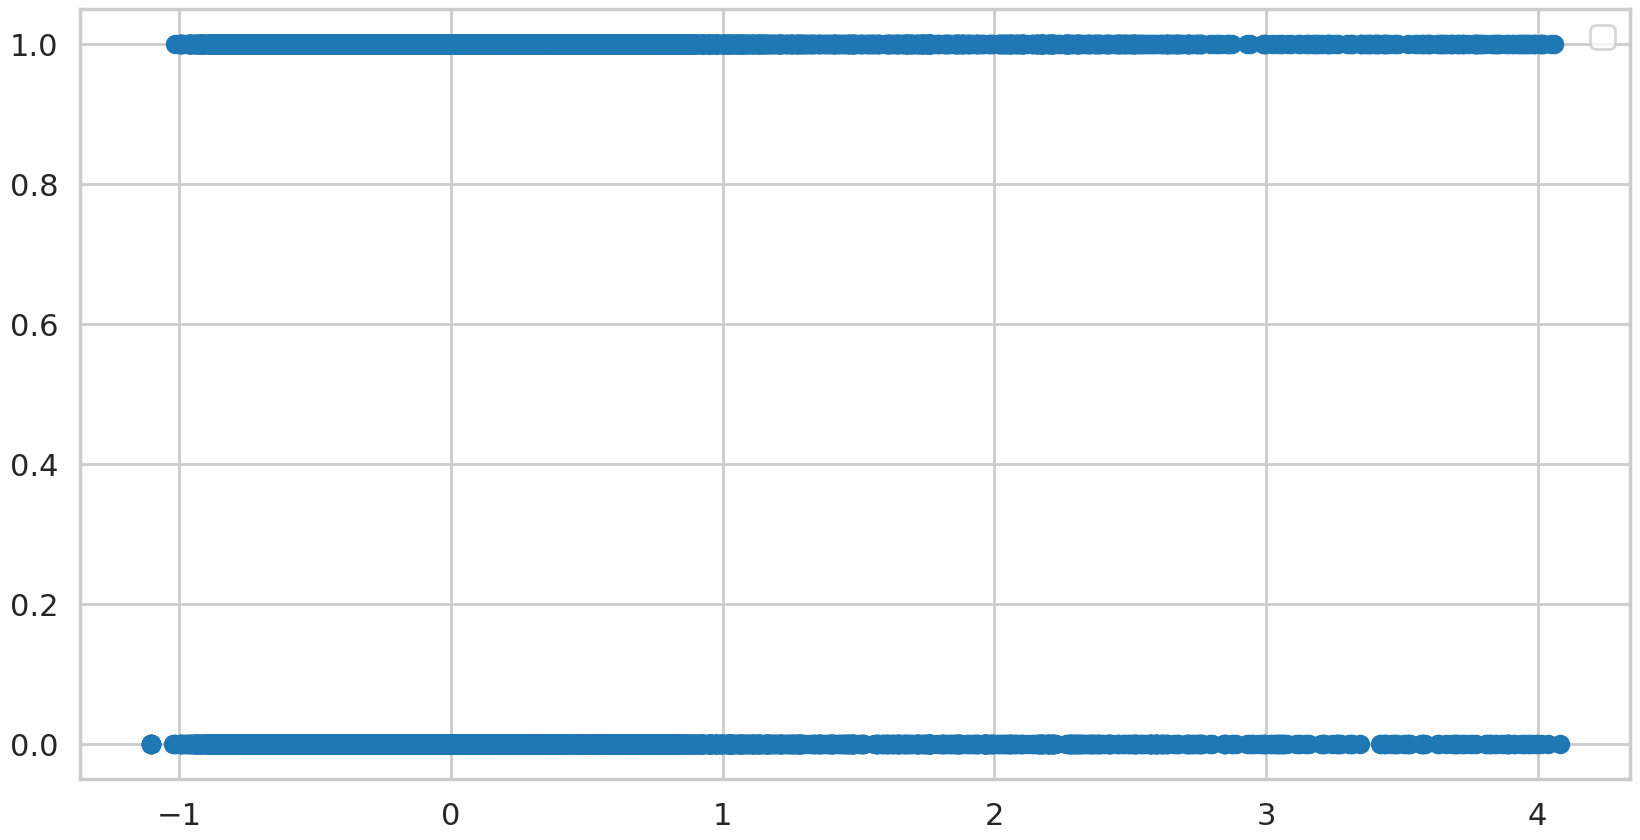

In [46]:
# make scatter plot of acoustic feature vs timestamp
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")
plt.figure(figsize=(20, 10))
# plt.plot((labels[idx_list,:]), feats[idx_list,:,42+acoustic_feats_to_idx["liveness"]])
# number of songs skipped vs liveness
plt.scatter(feats[idx_list,:,42+acoustic_feats_to_idx["liveness"]], (labels[idx_list,:]))
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


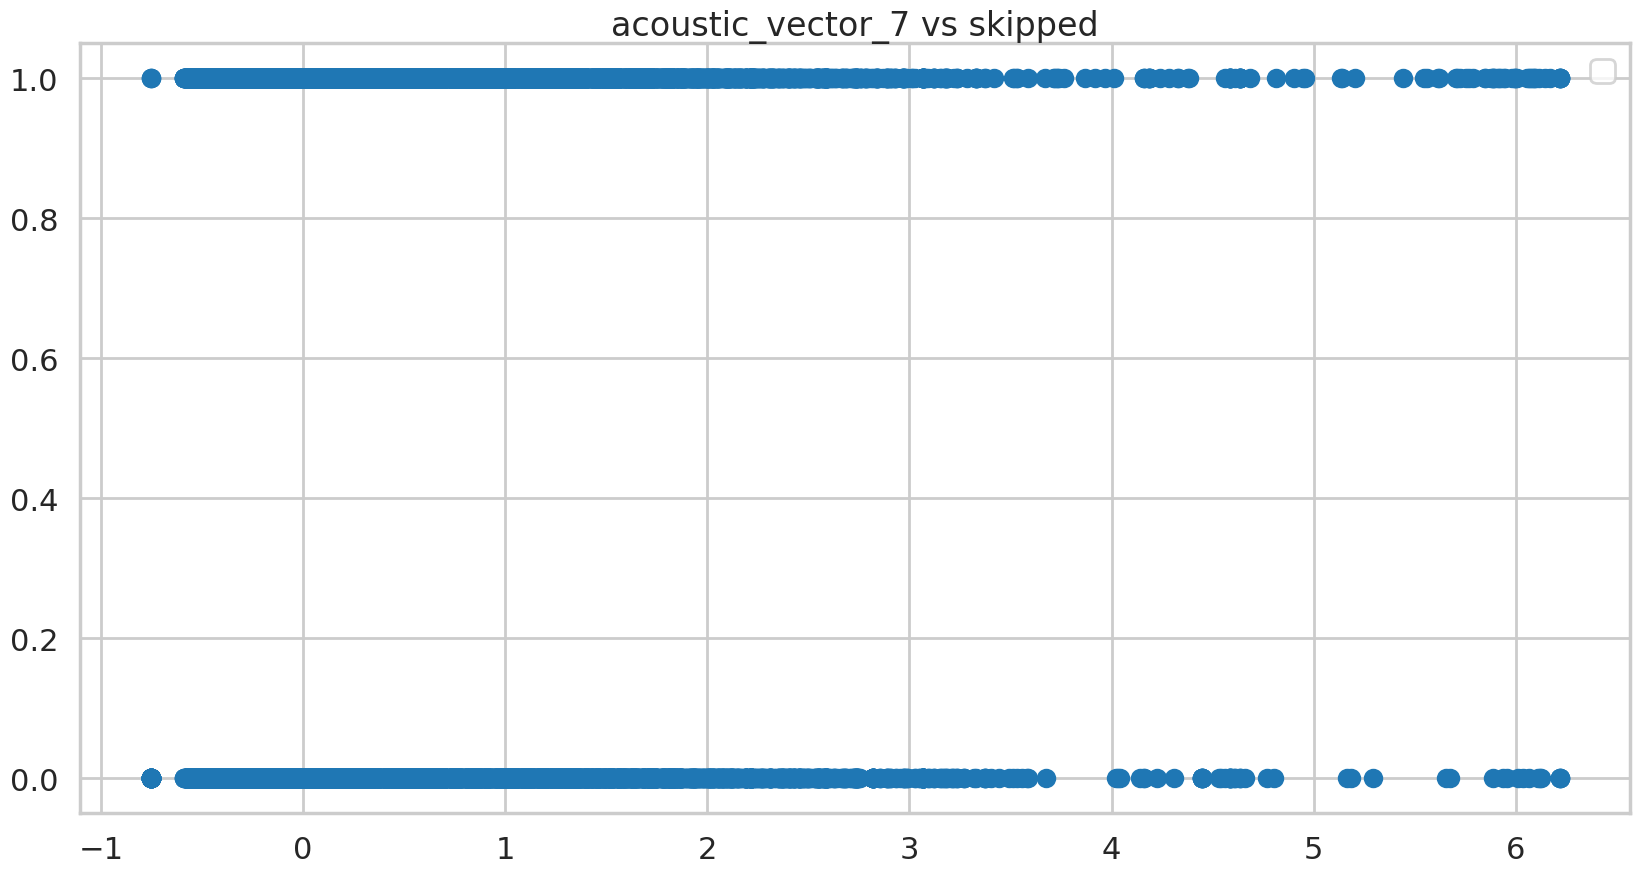

In [49]:
# make scatter plot of acoustic feature vs timestamp
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")
plt.figure(figsize=(20, 10))
# plt.plot((labels[idx_list,:]), feats[idx_list,:,42+acoustic_feats_to_idx["liveness"]])
# number of songs skipped vs liveness
plt.title(f"{feat} vs skipped")
plt.scatter(feats[idx_list,:,42+acoustic_feats_to_idx["speechiness"]], (labels[idx_list,:]))
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


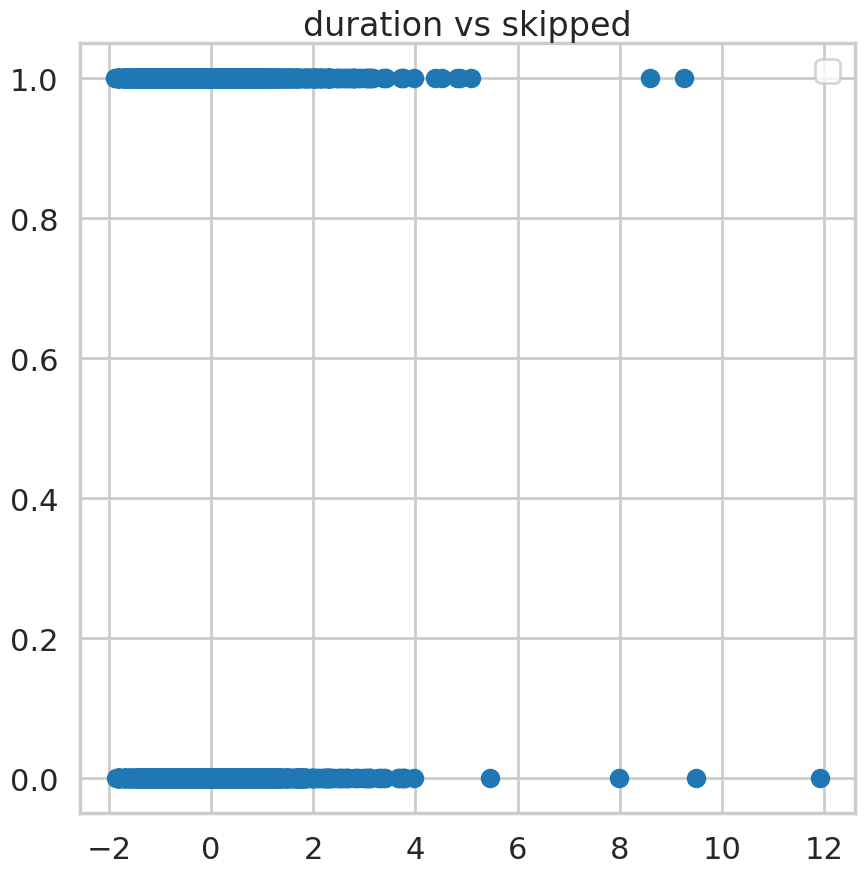

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


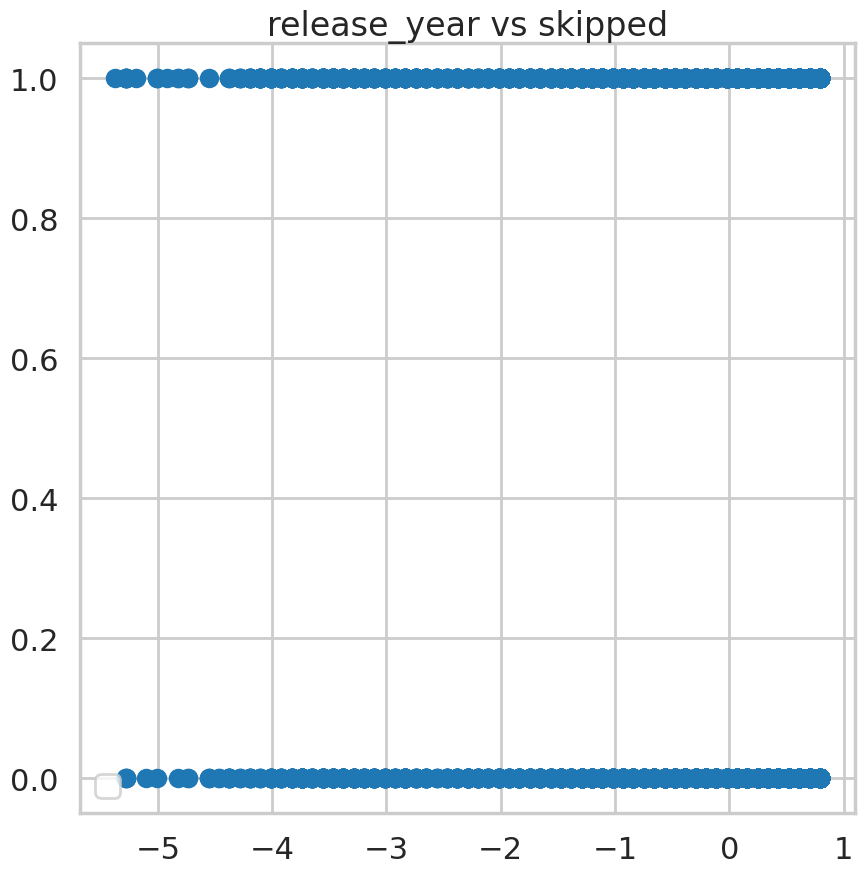

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


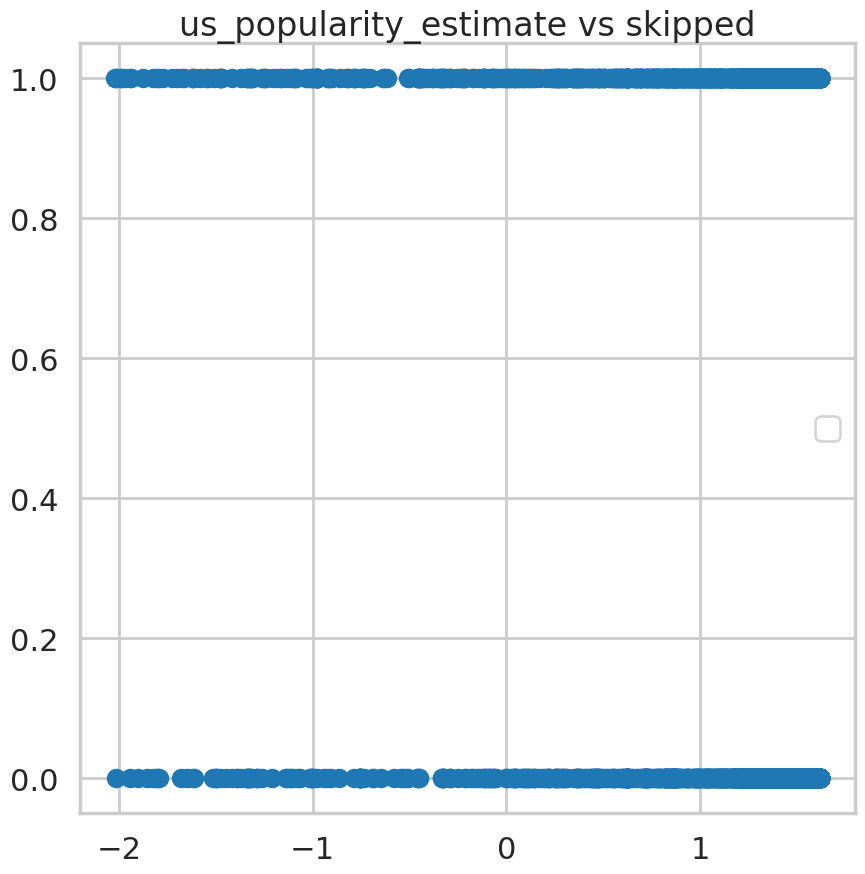

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


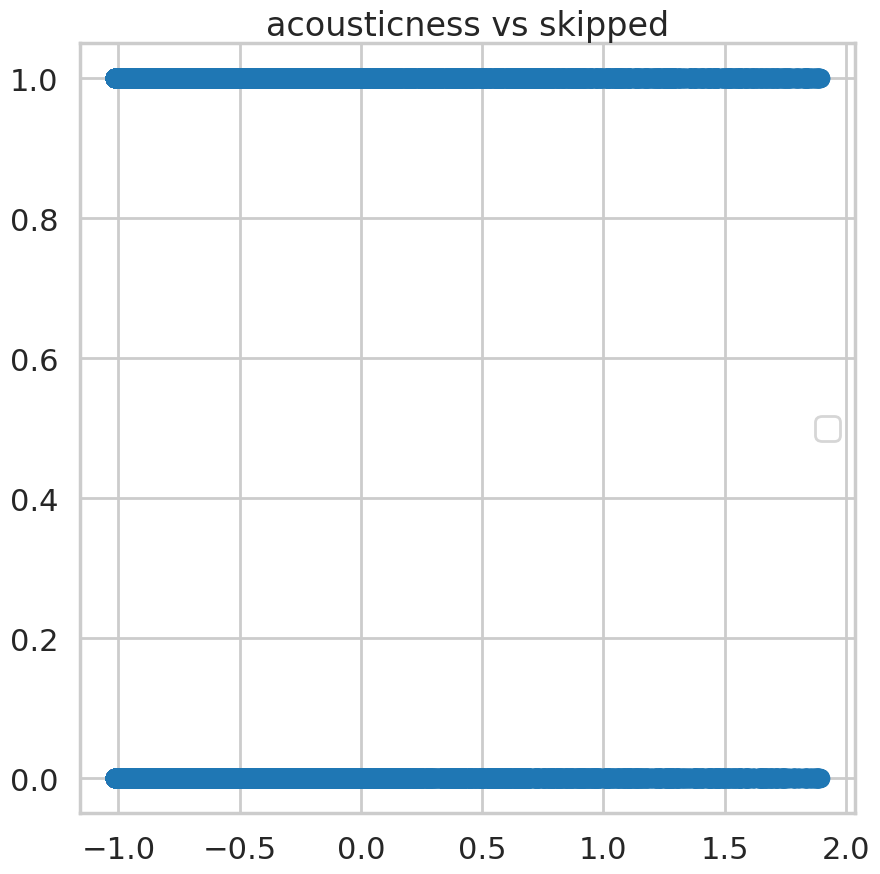

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


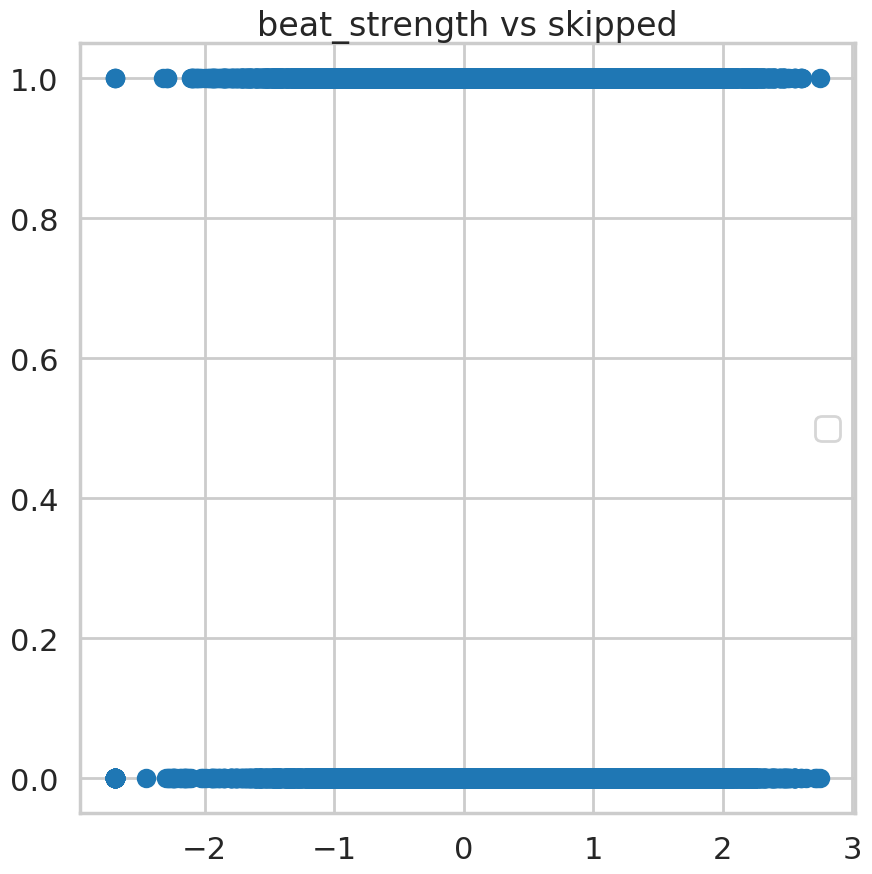

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


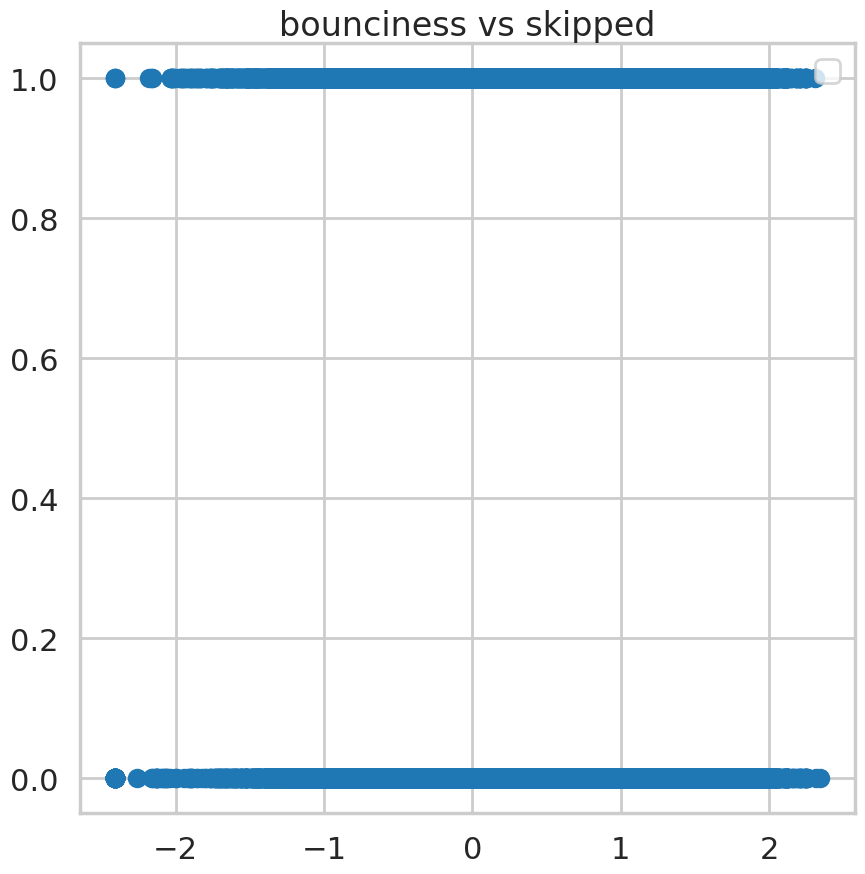

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


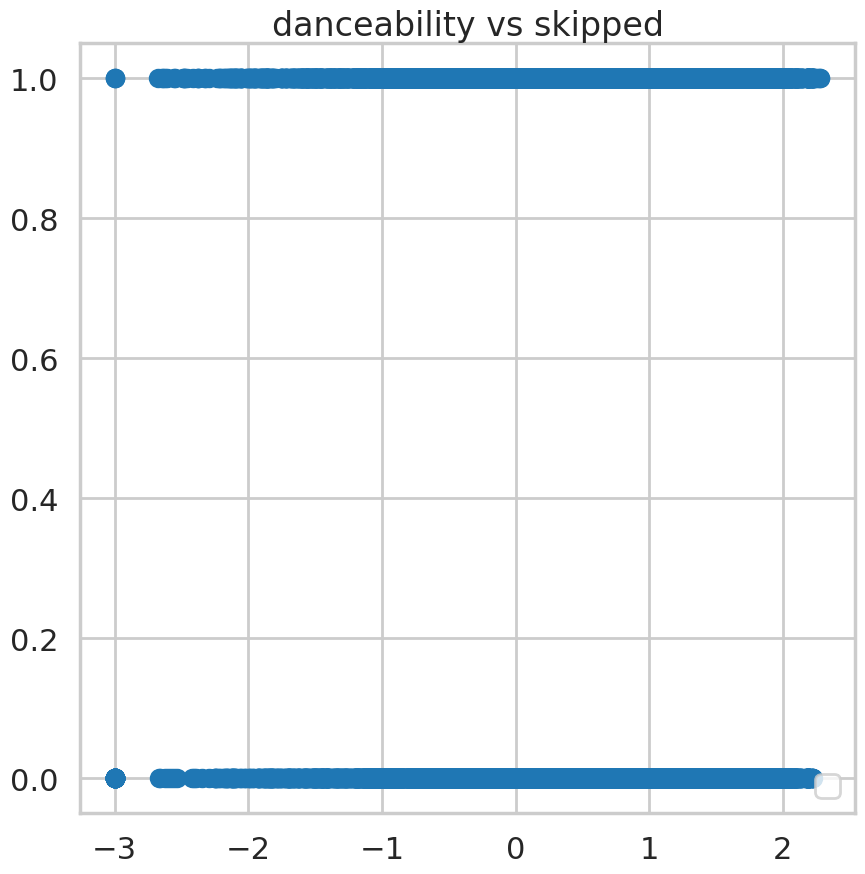

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


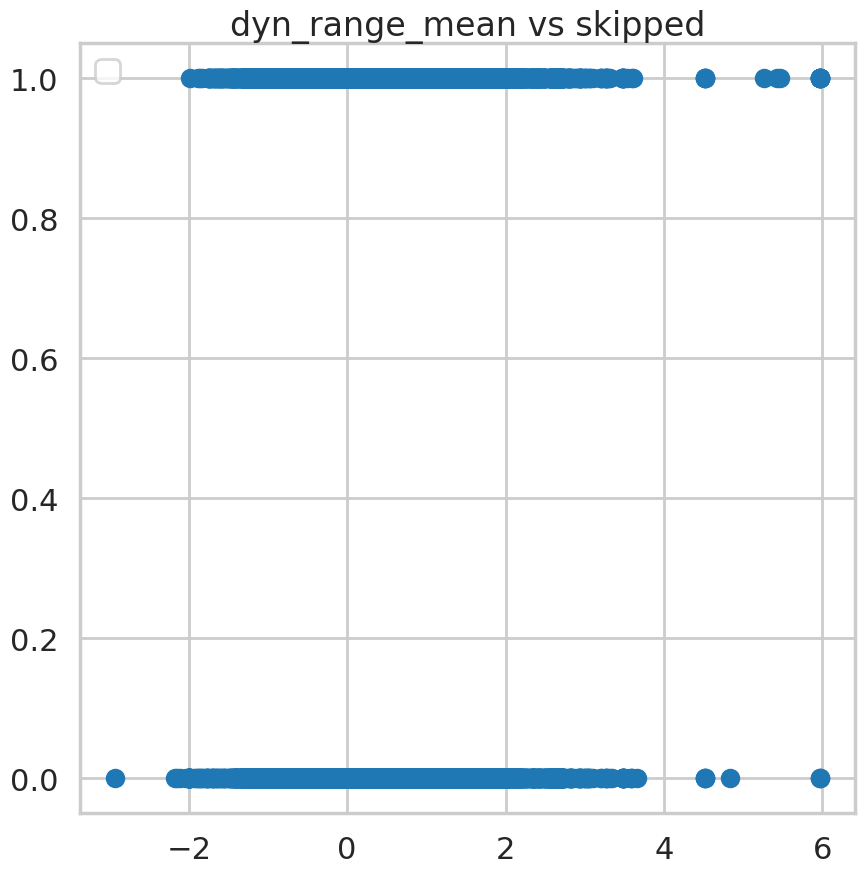

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


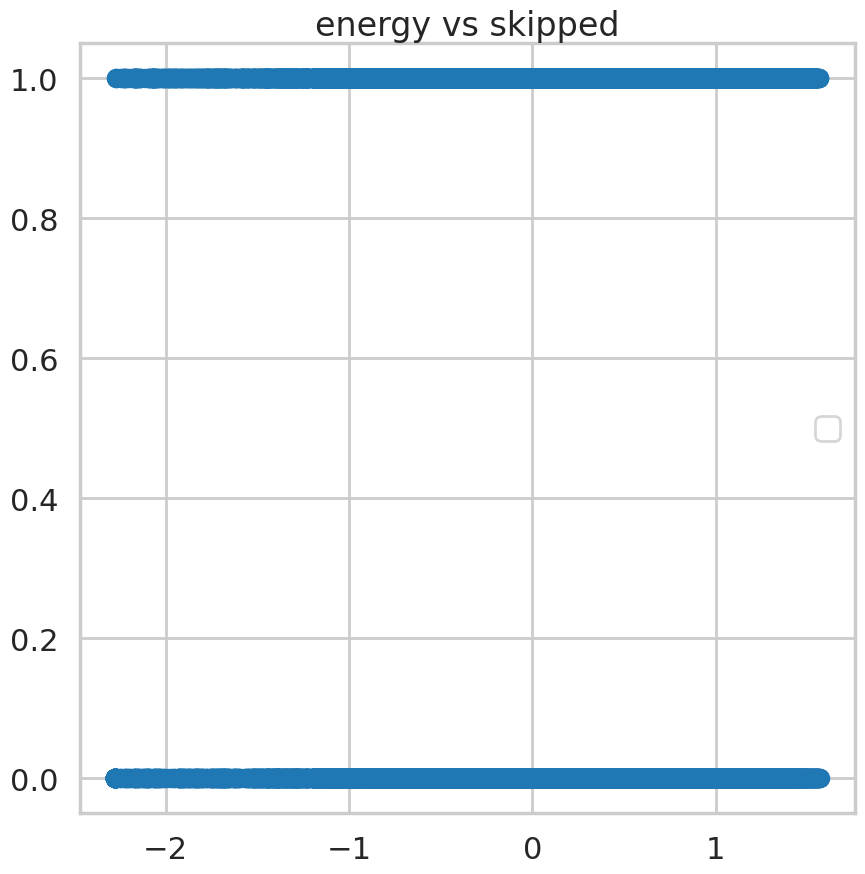

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


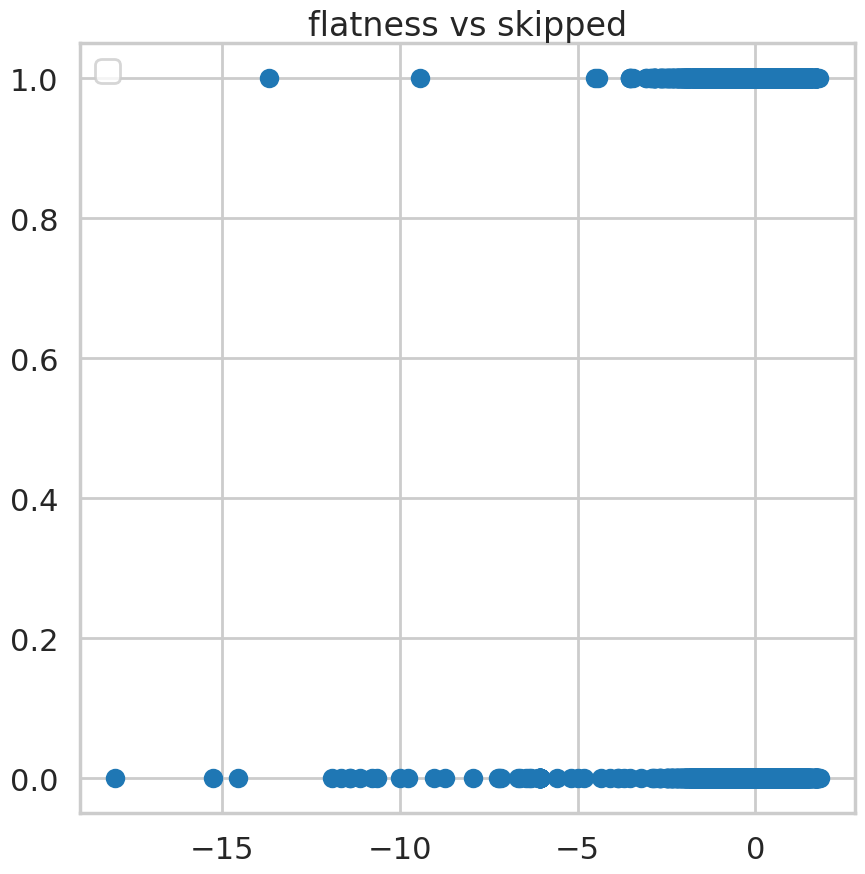

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


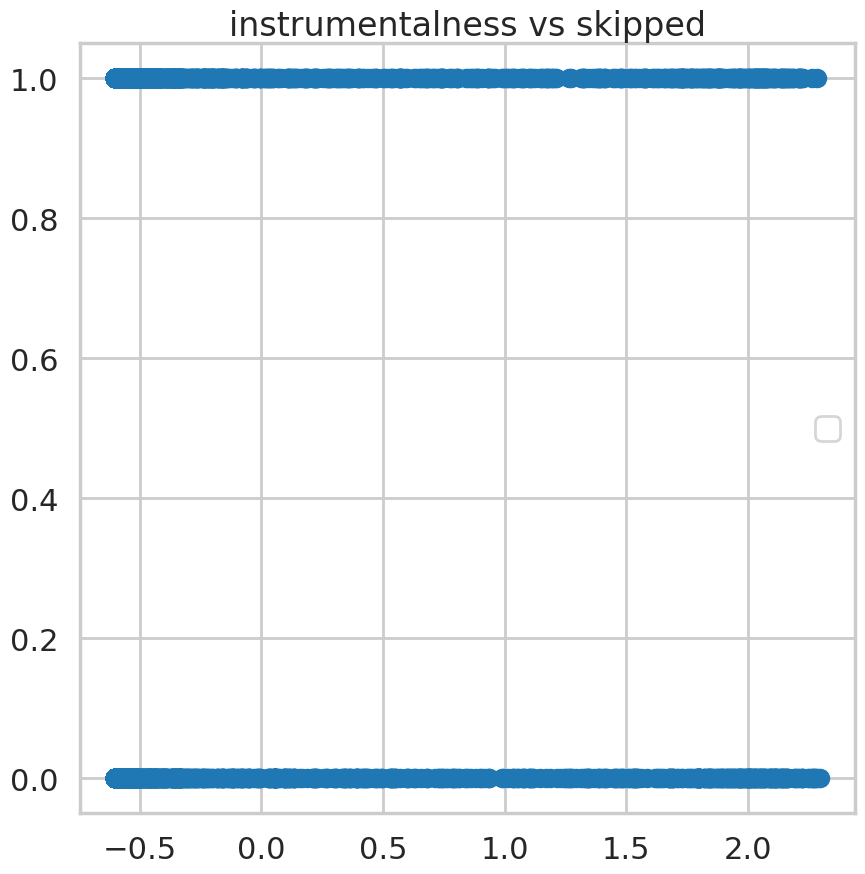

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


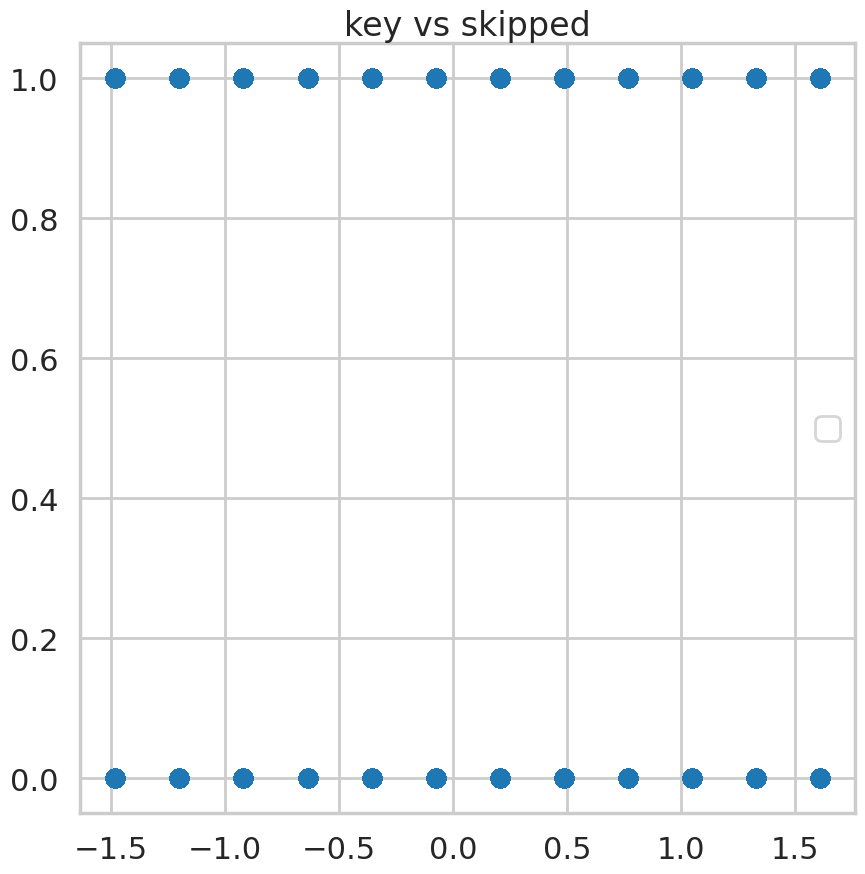

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


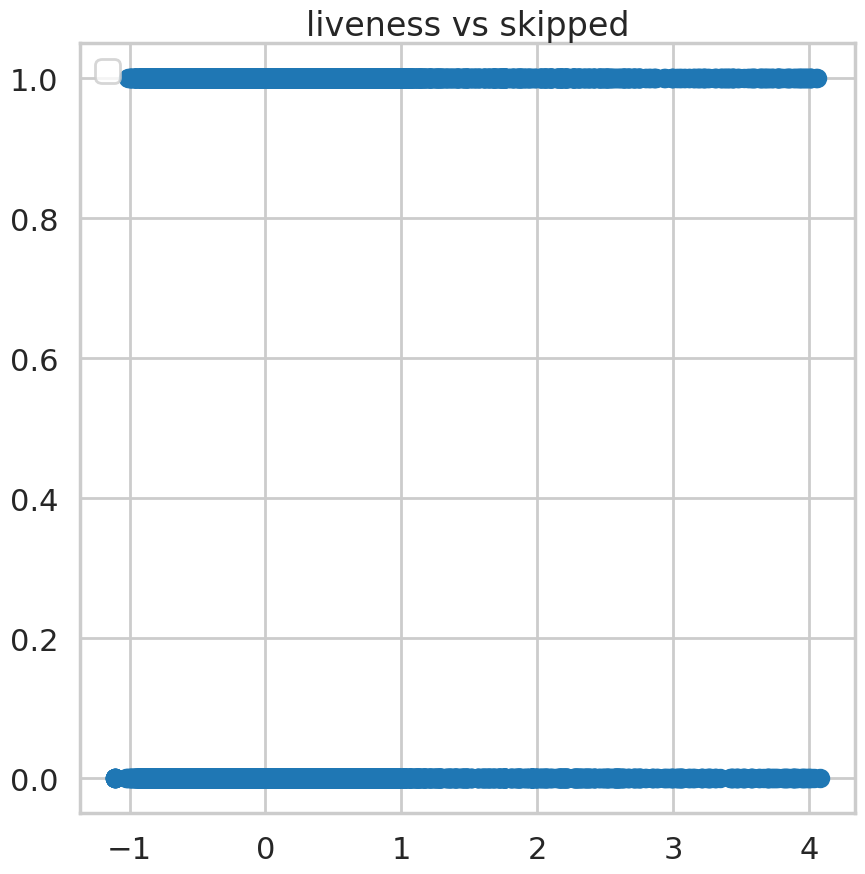

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


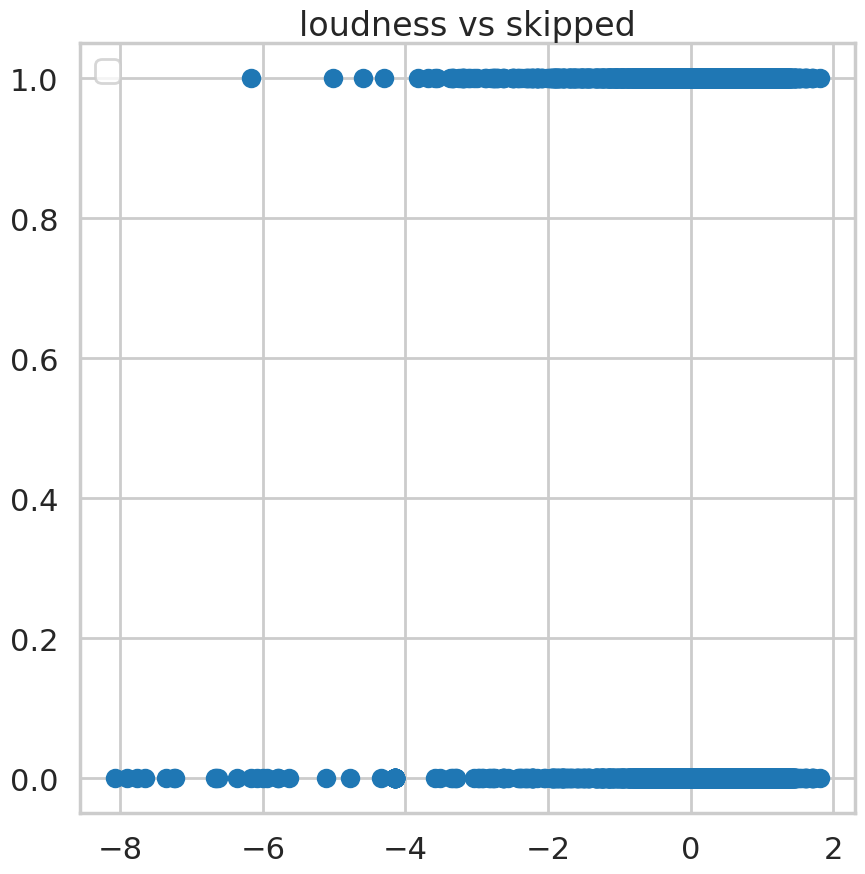

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


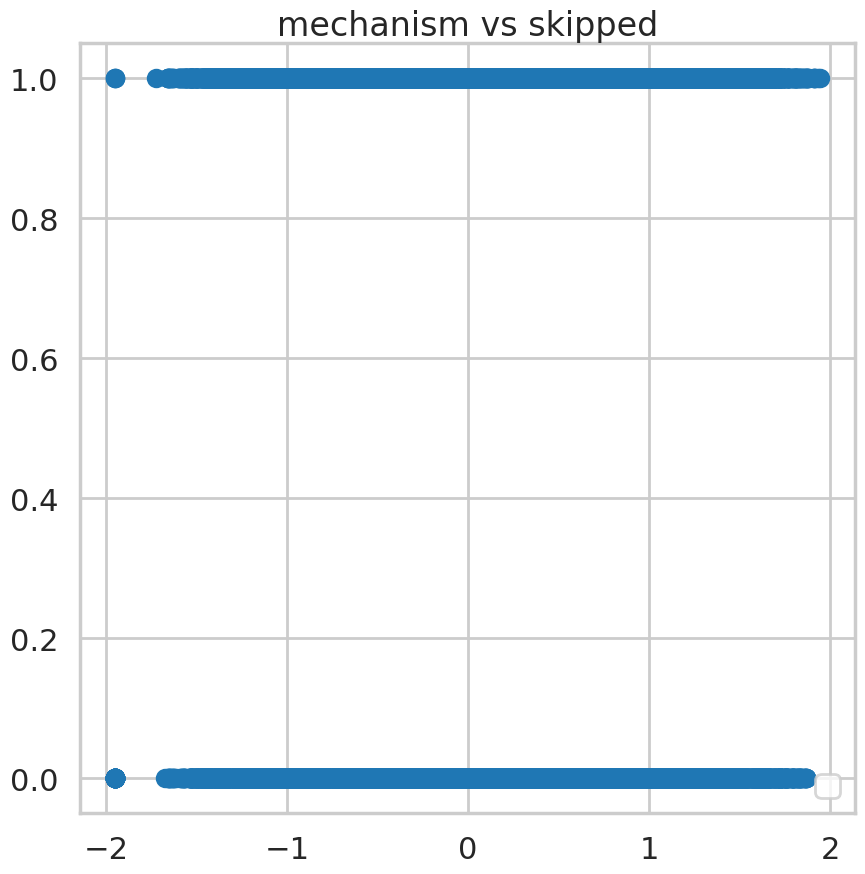

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


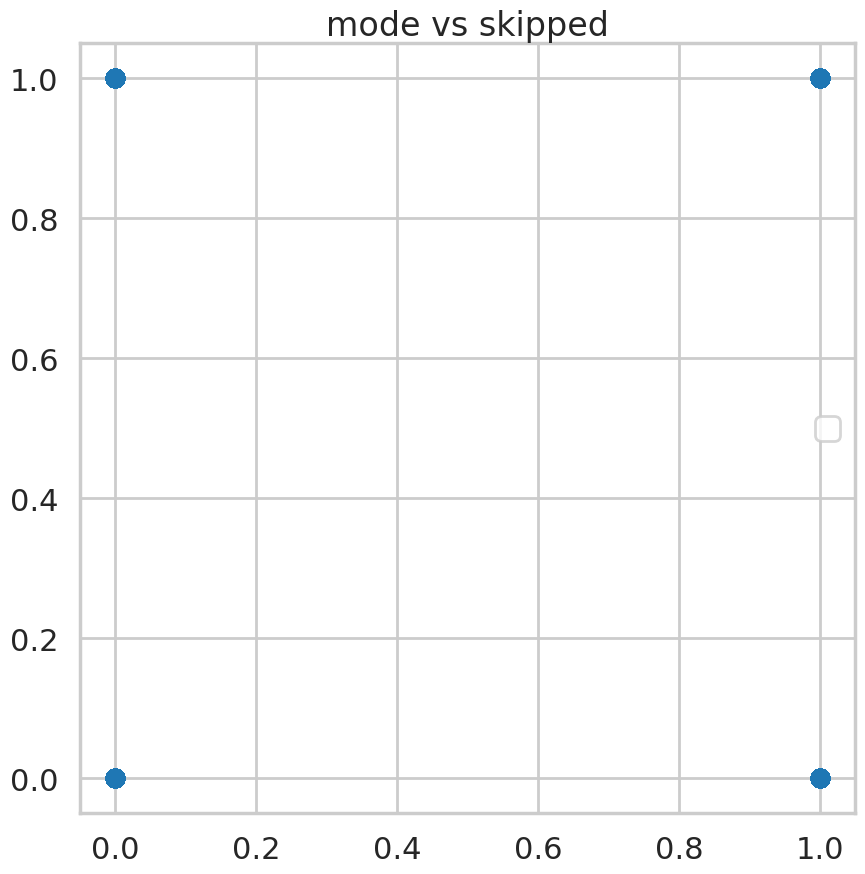

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


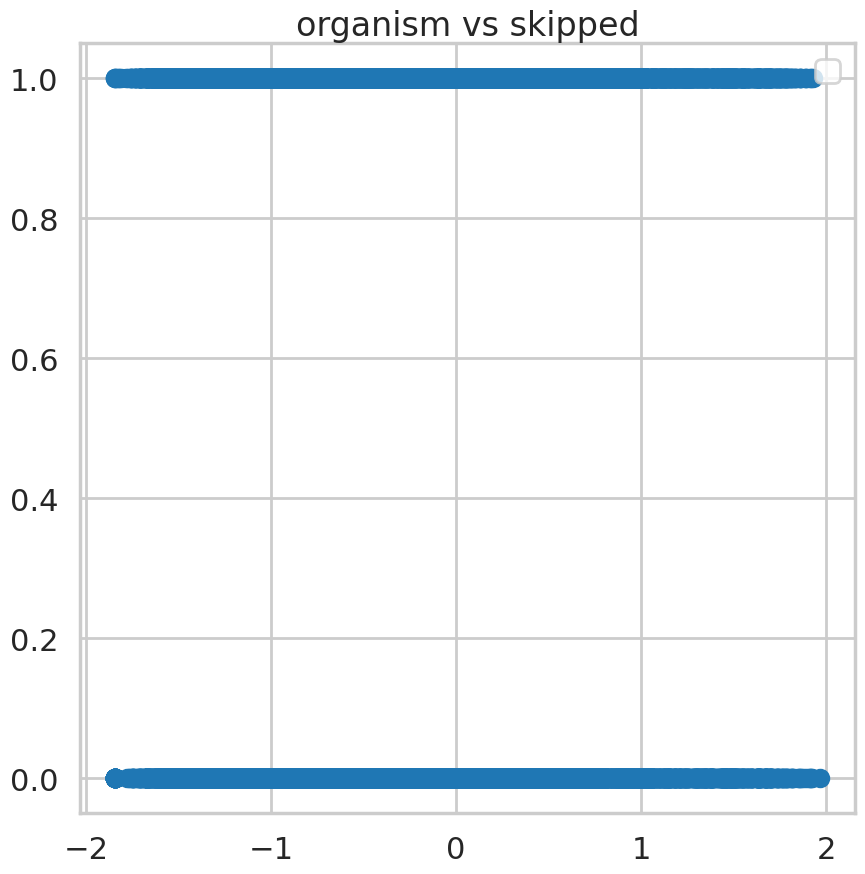

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


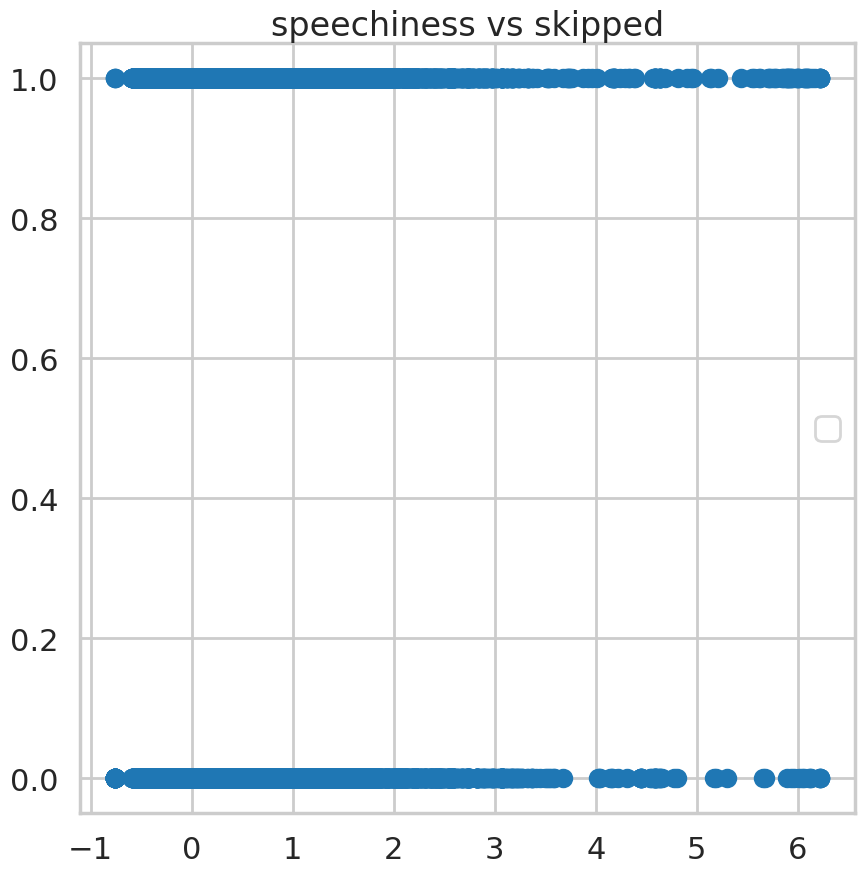

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


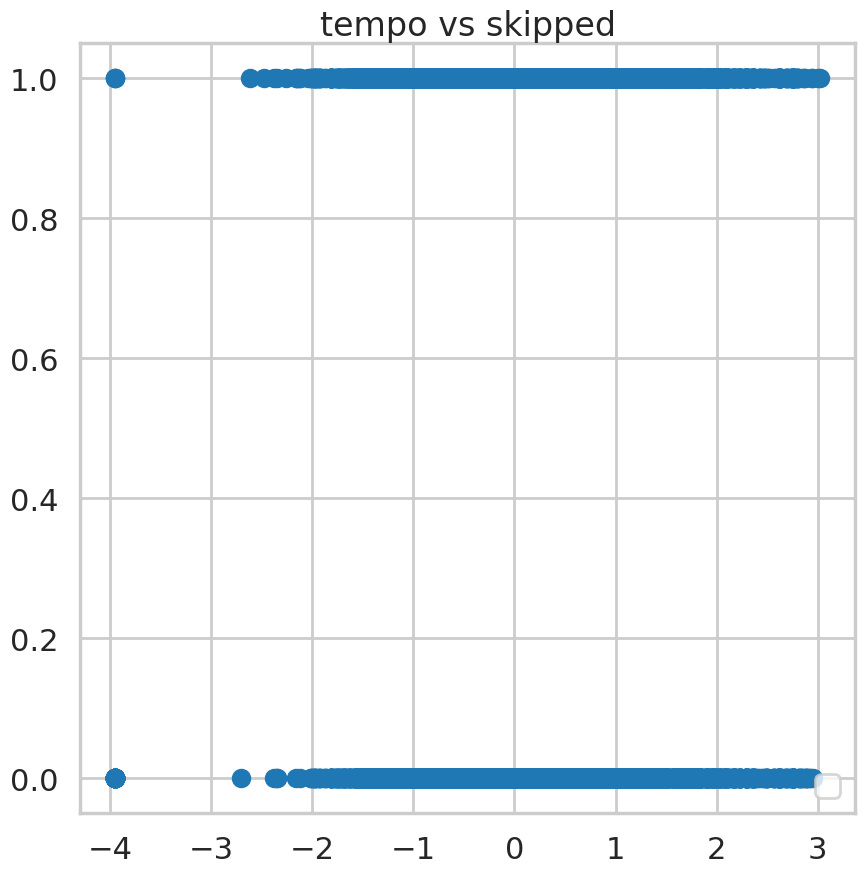

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


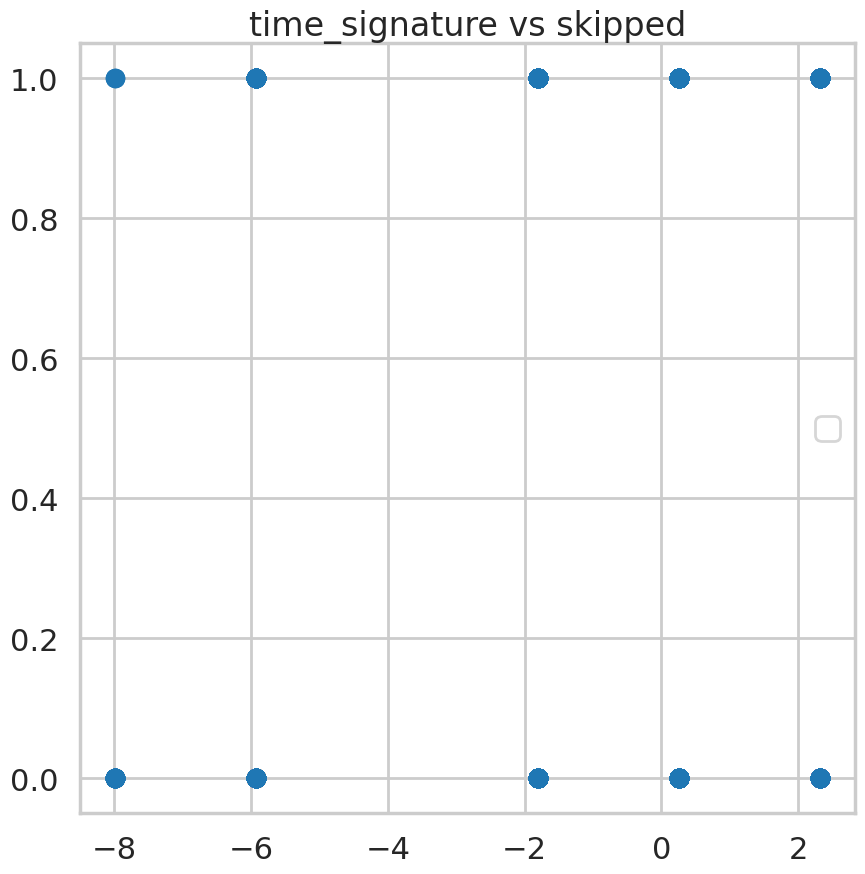

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


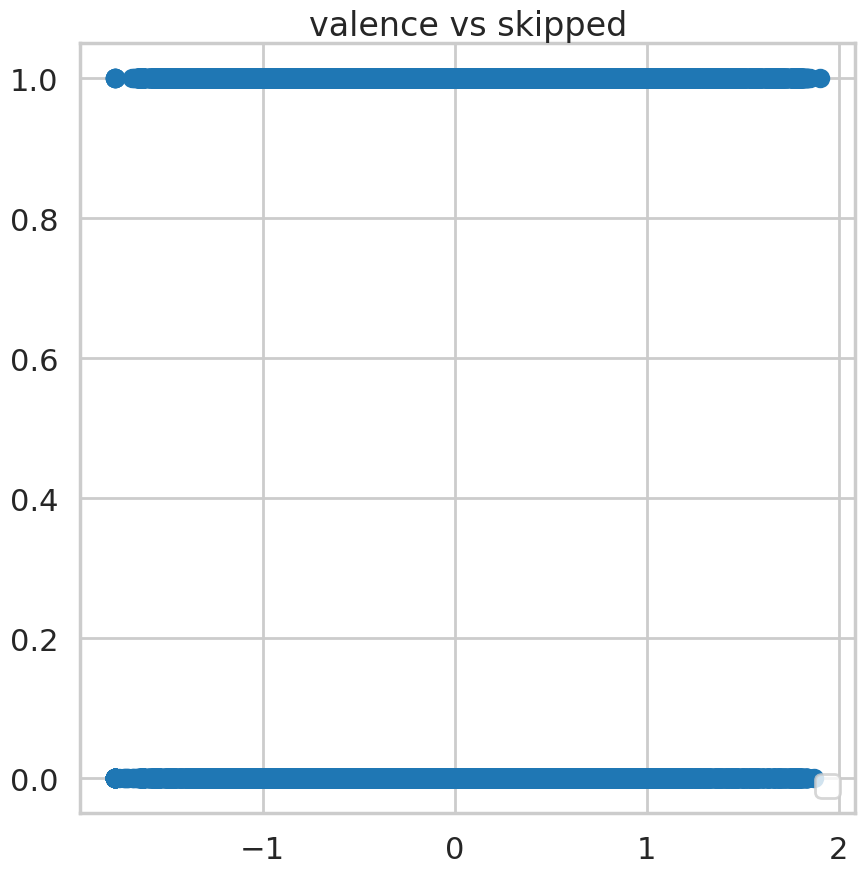

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


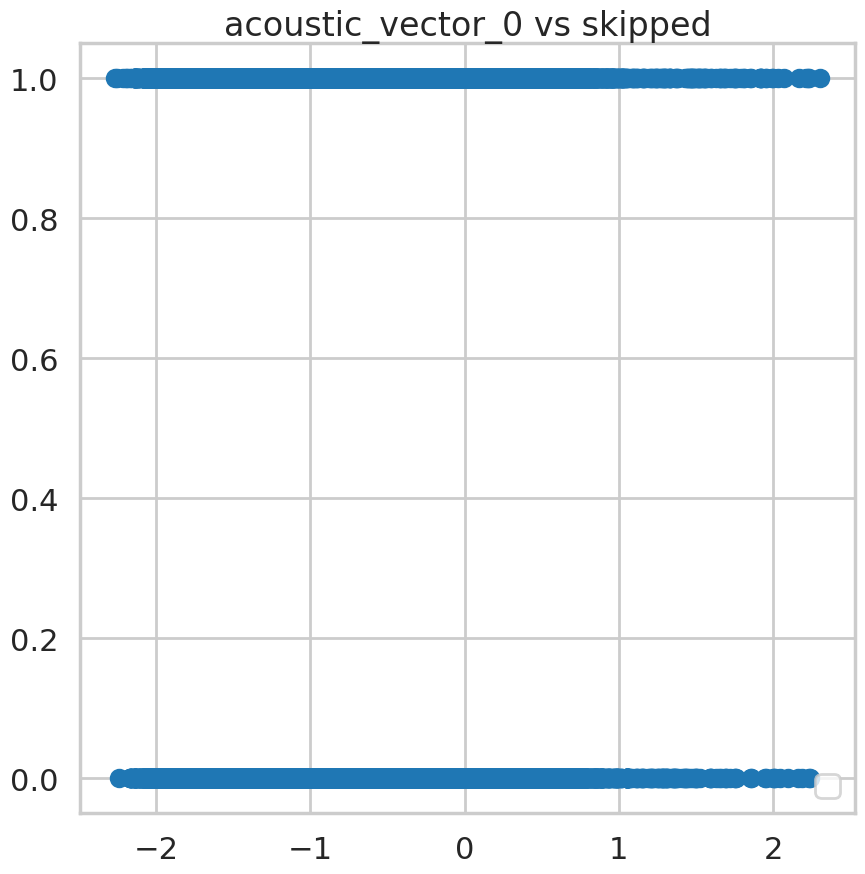

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


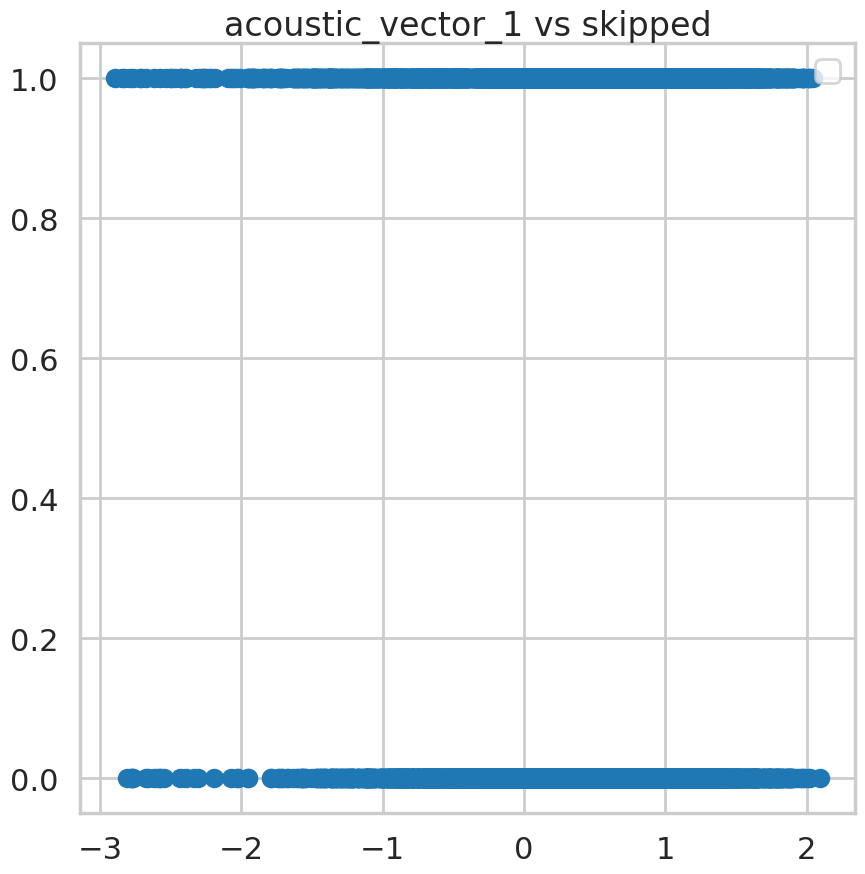

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


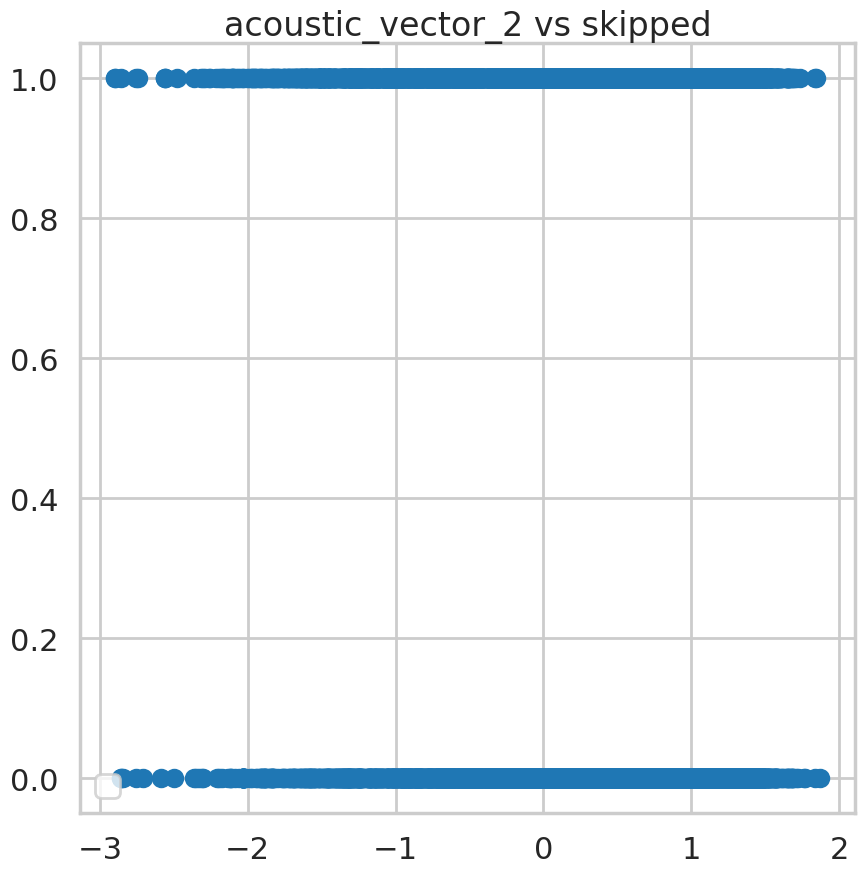

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


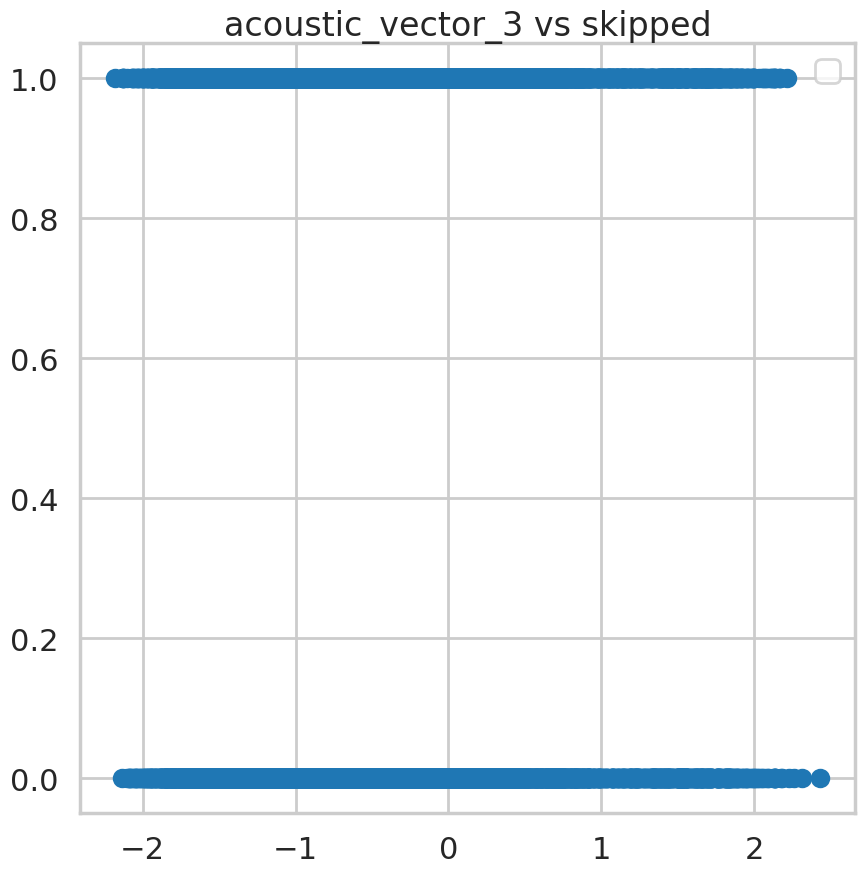

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


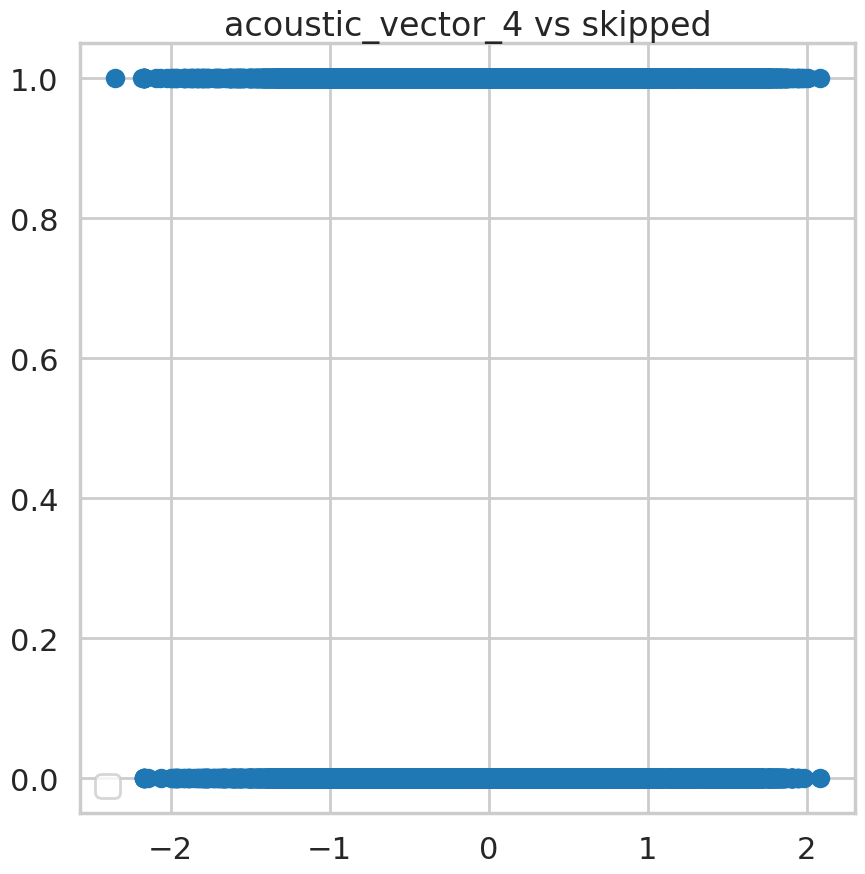

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


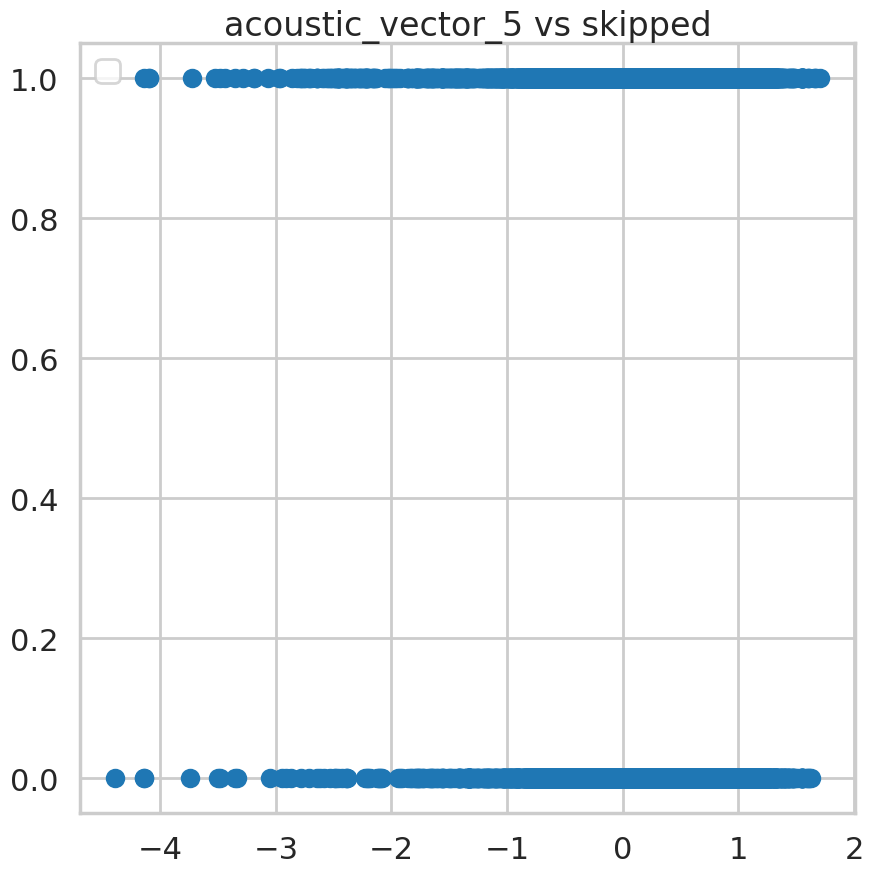

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


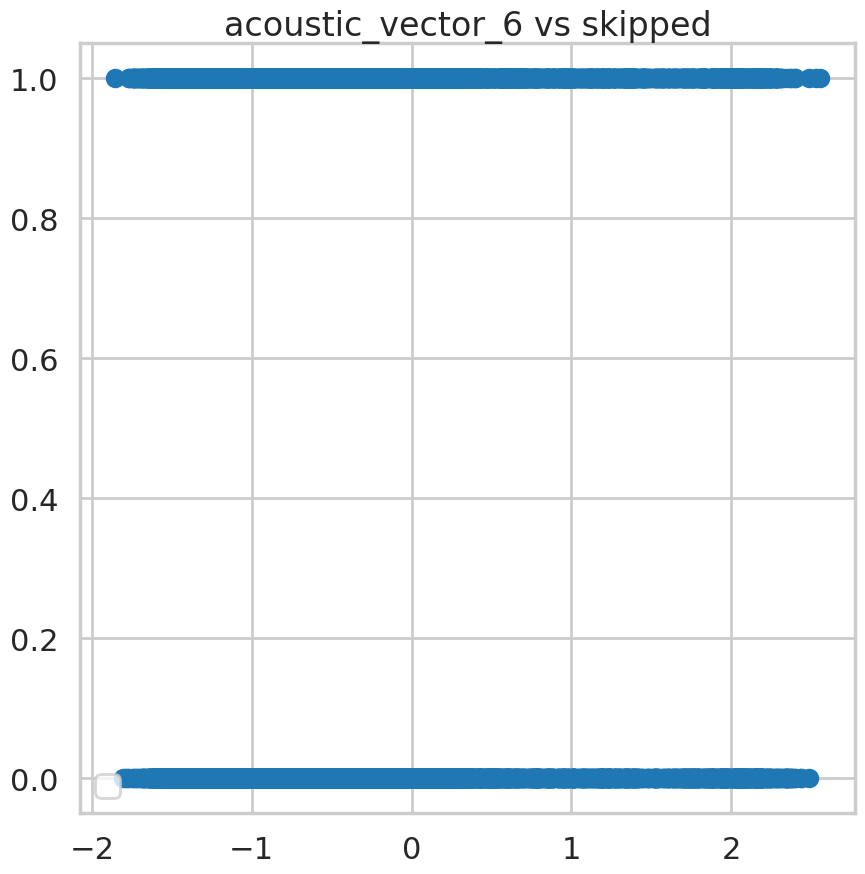

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


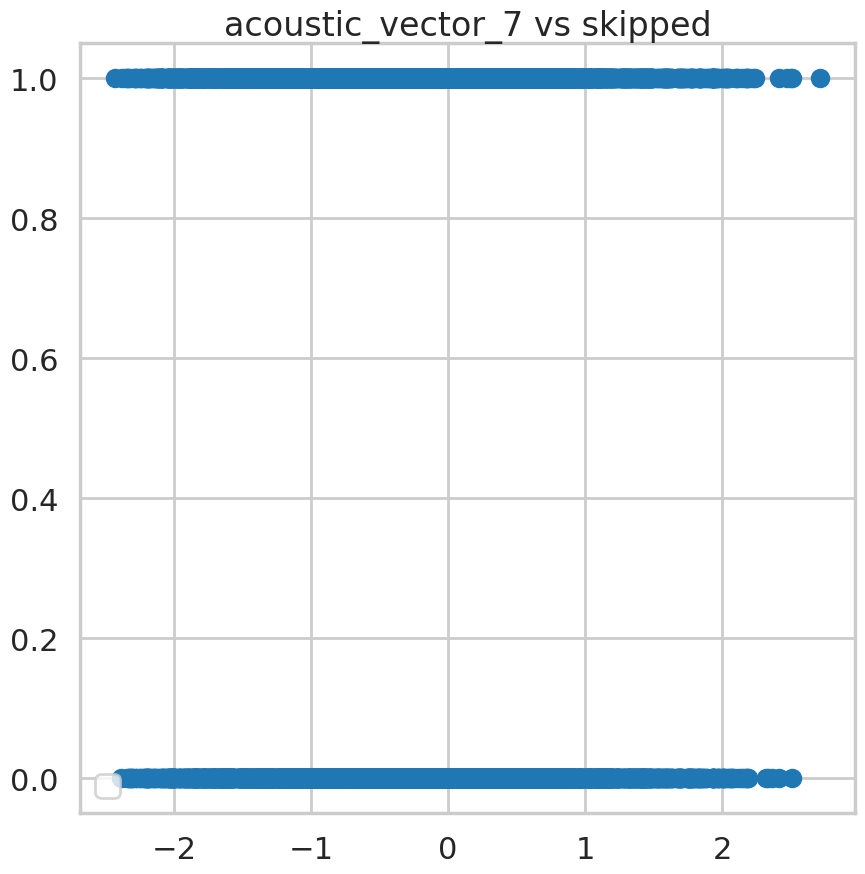

In [50]:
# make scatter plot of acoustic feature vs timestamp
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")
for feat in acoustic_feats:
    plt.figure(figsize=(10, 10))
    # plt.plot((labels[idx_list,:]), feats[idx_list,:,42+acoustic_feats_to_idx["liveness"]])
    # number of songs skipped vs liveness
    plt.title(f"{feat} vs skipped")
    plt.scatter(feats[idx_list,:,42+acoustic_feats_to_idx[feat]], (labels[idx_list,:]))
    plt.legend()
    plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


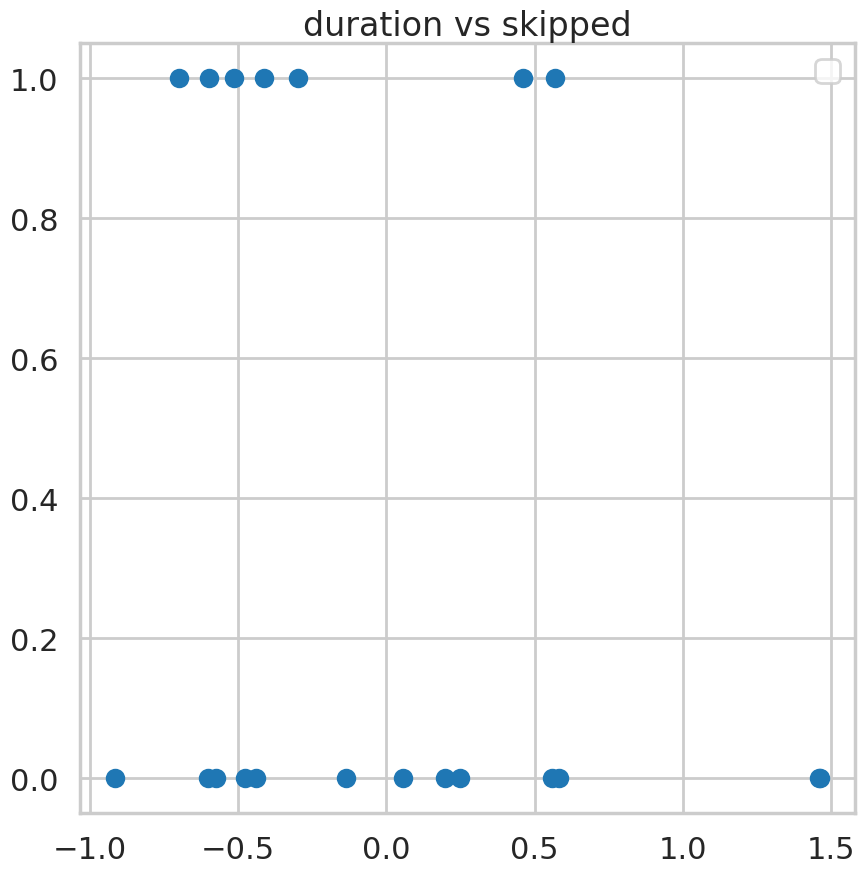

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


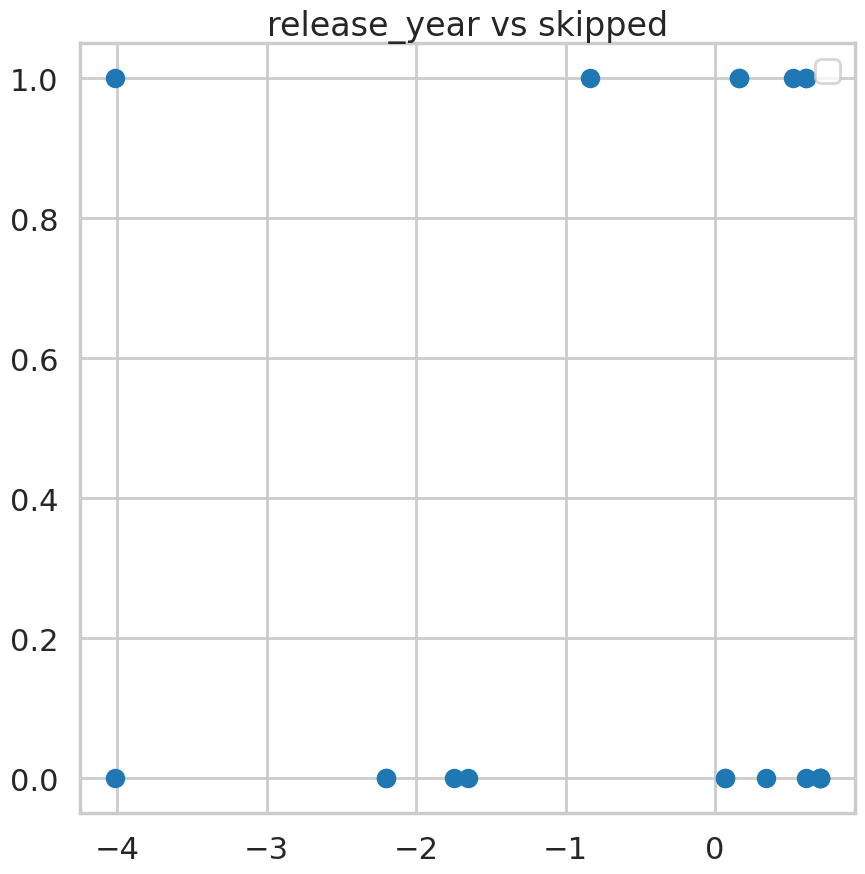

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


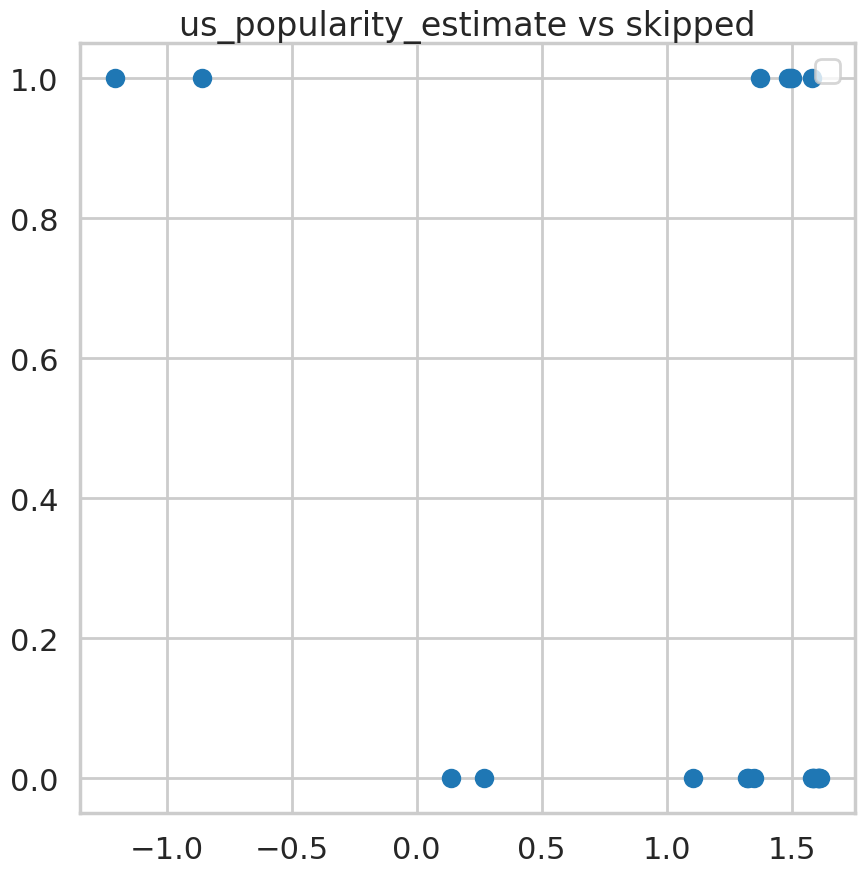

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


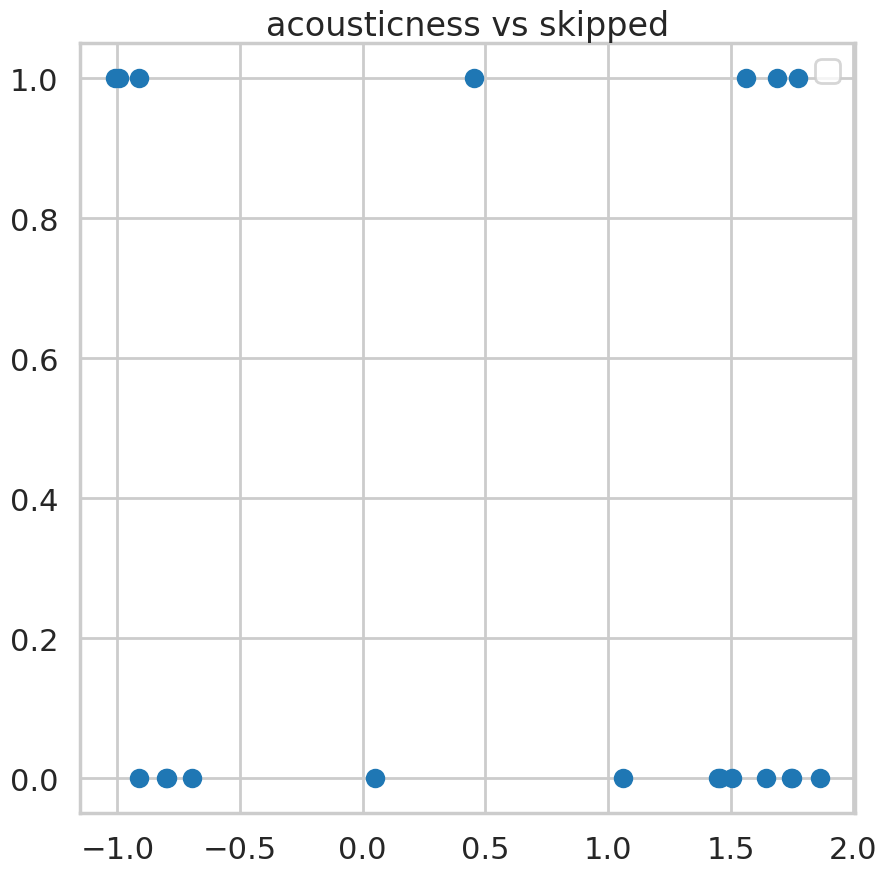

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


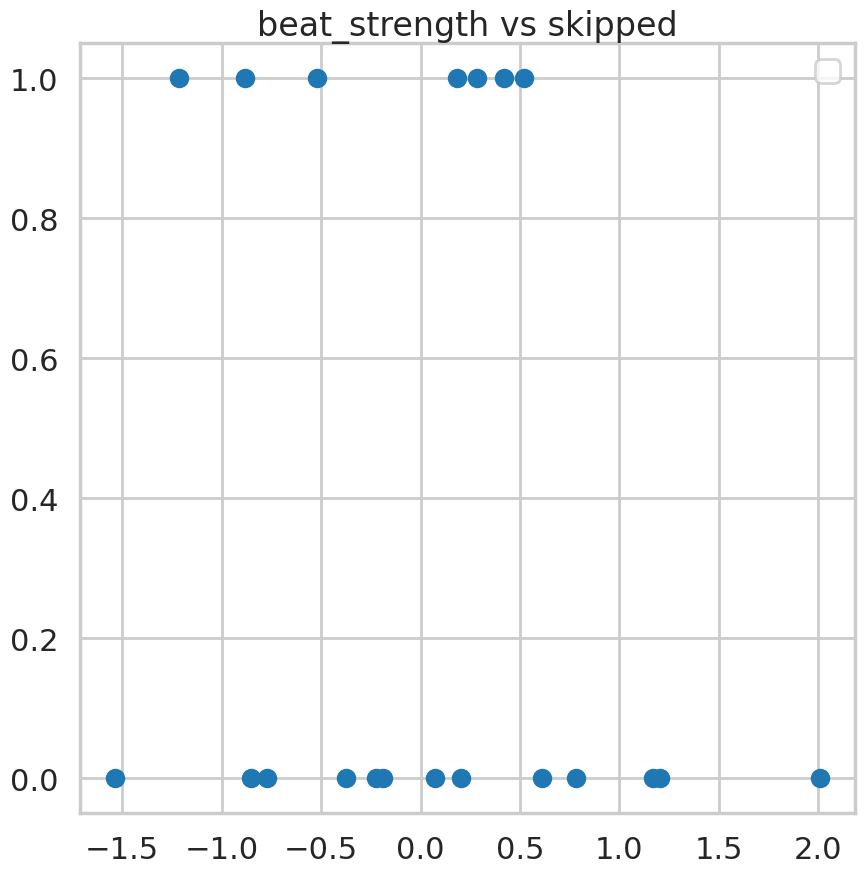

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


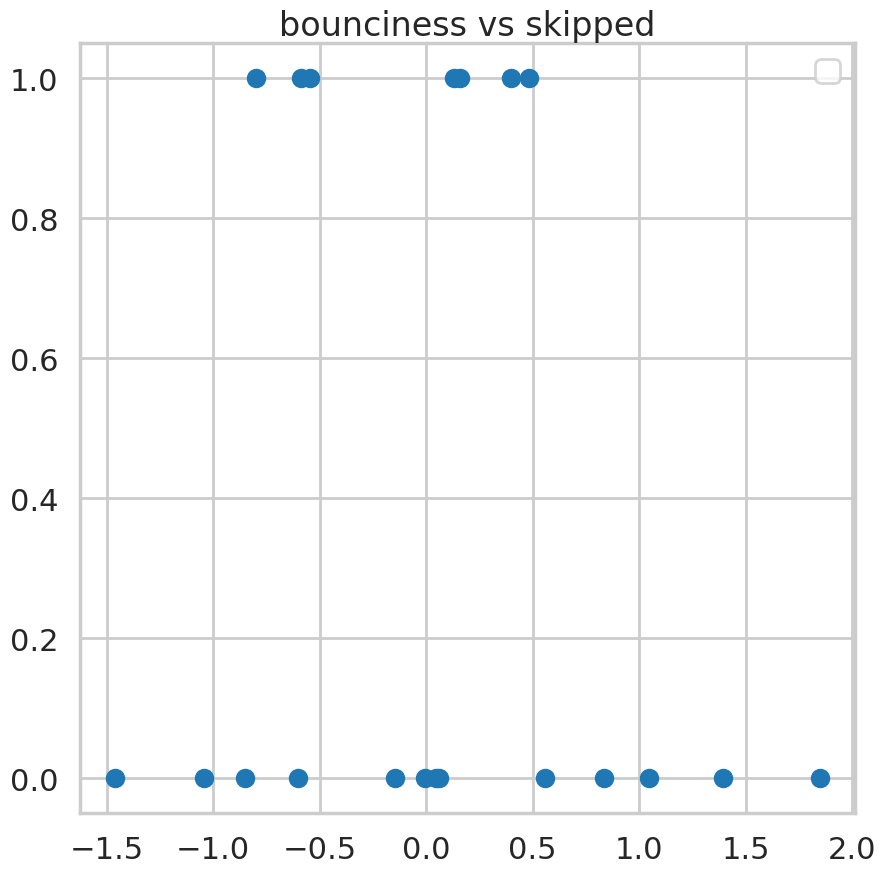

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


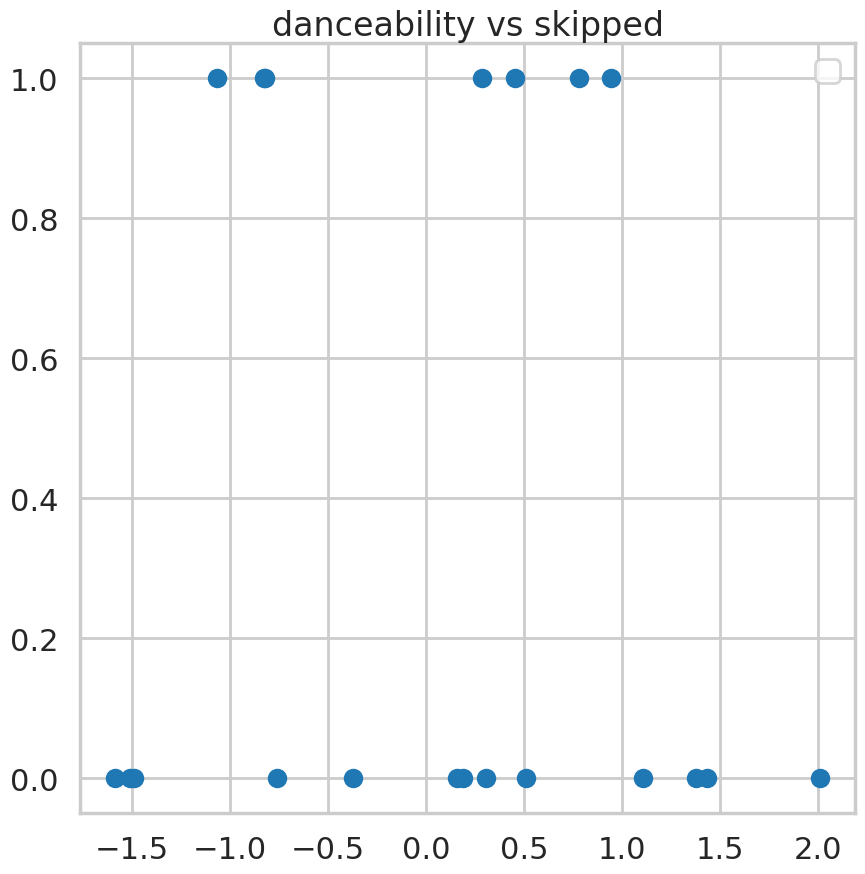

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


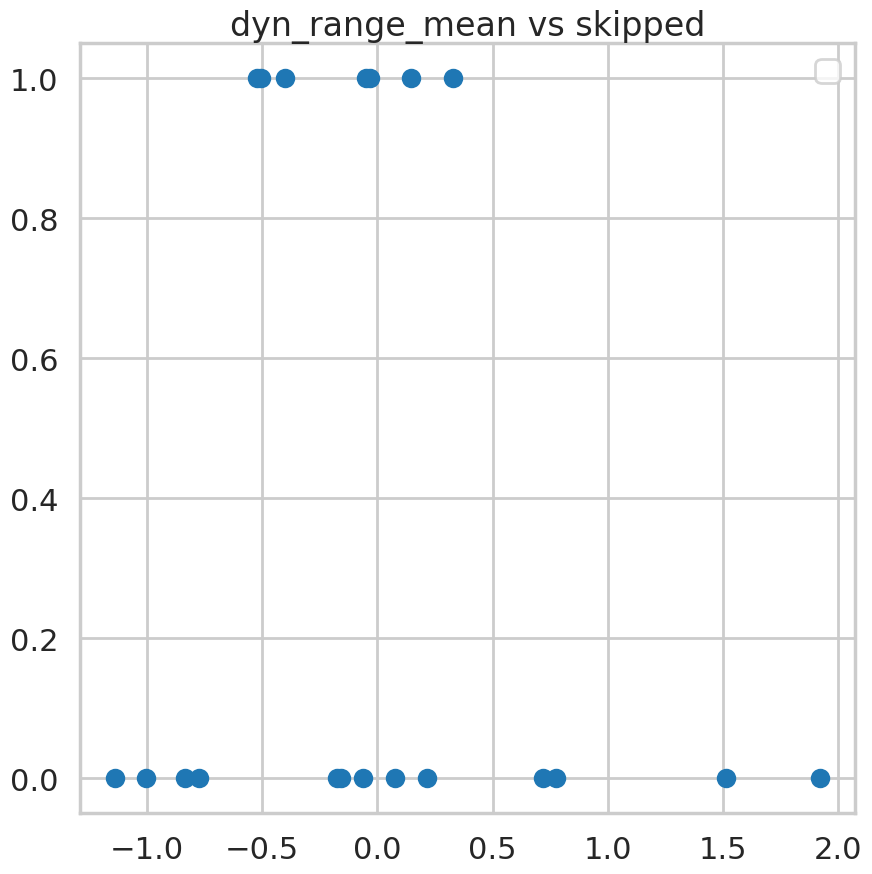

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


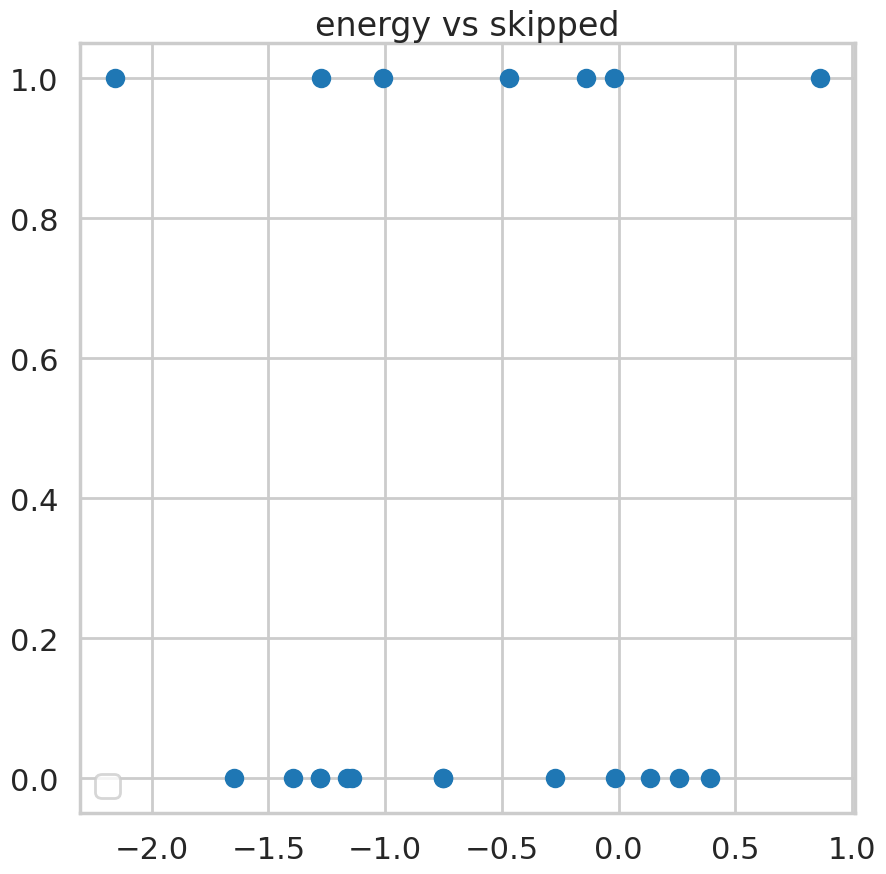

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


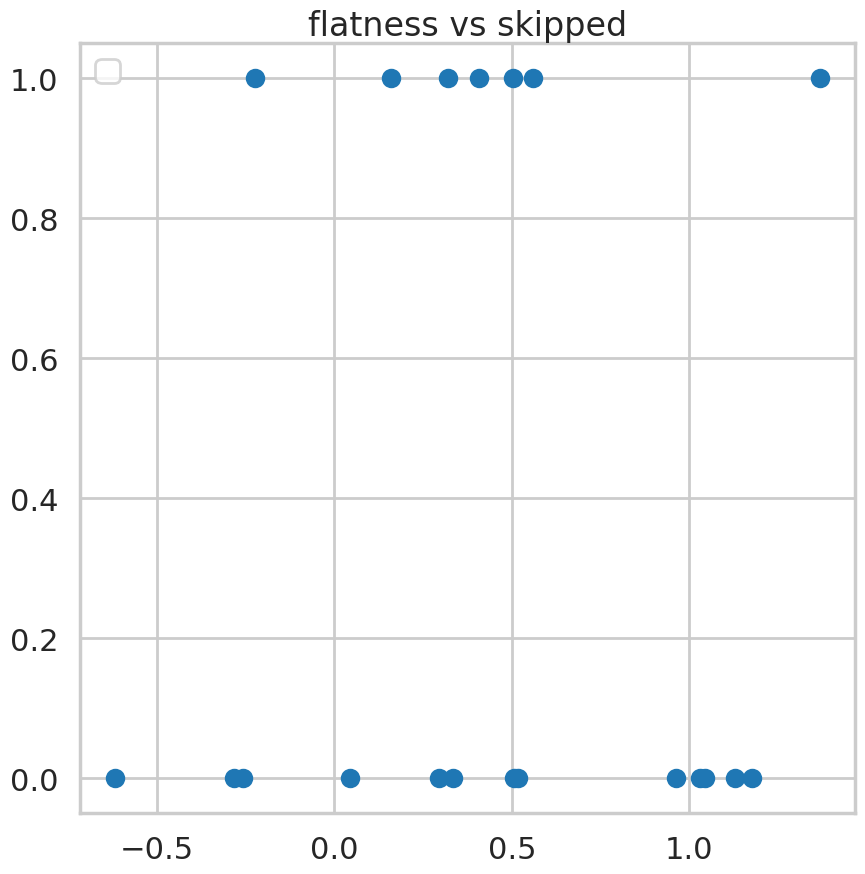

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


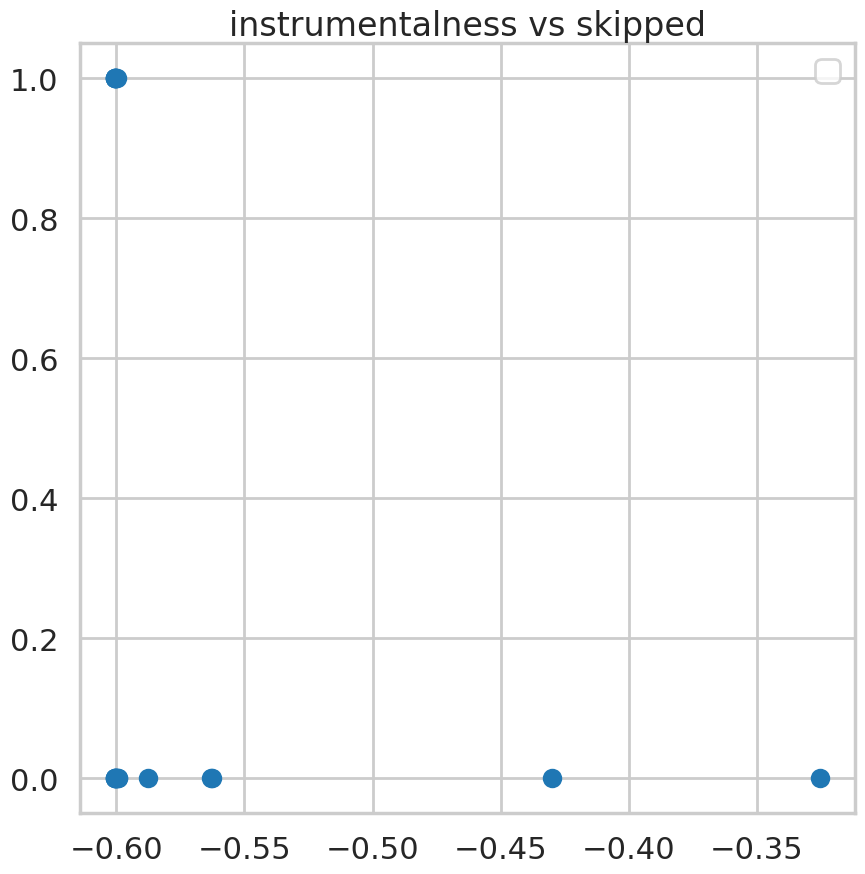

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


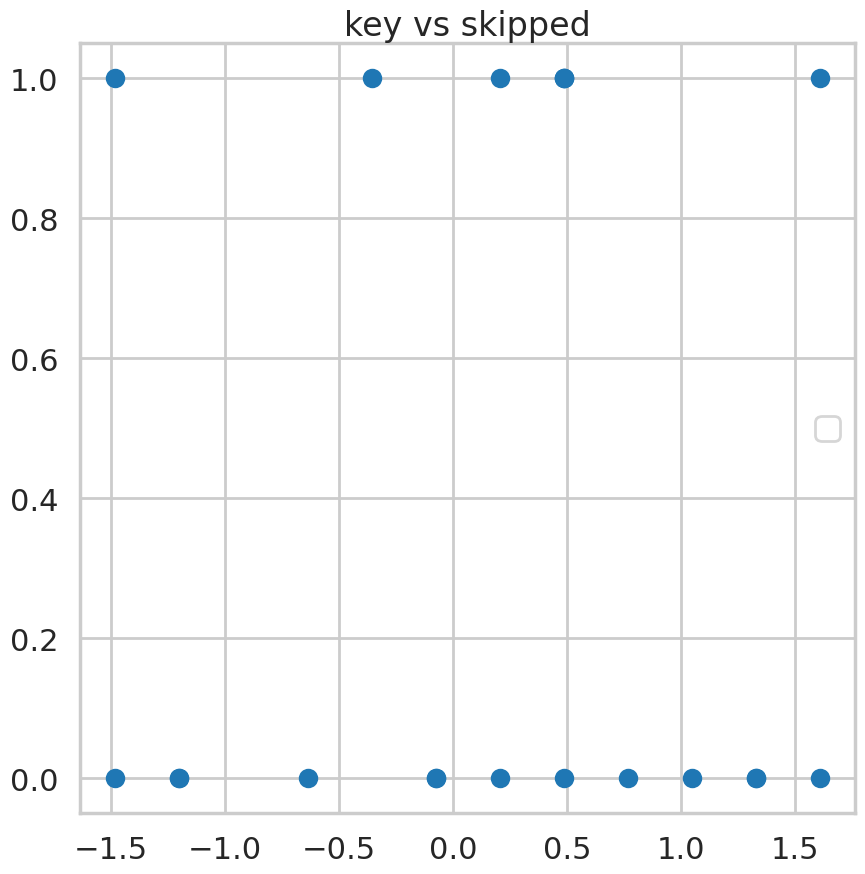

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


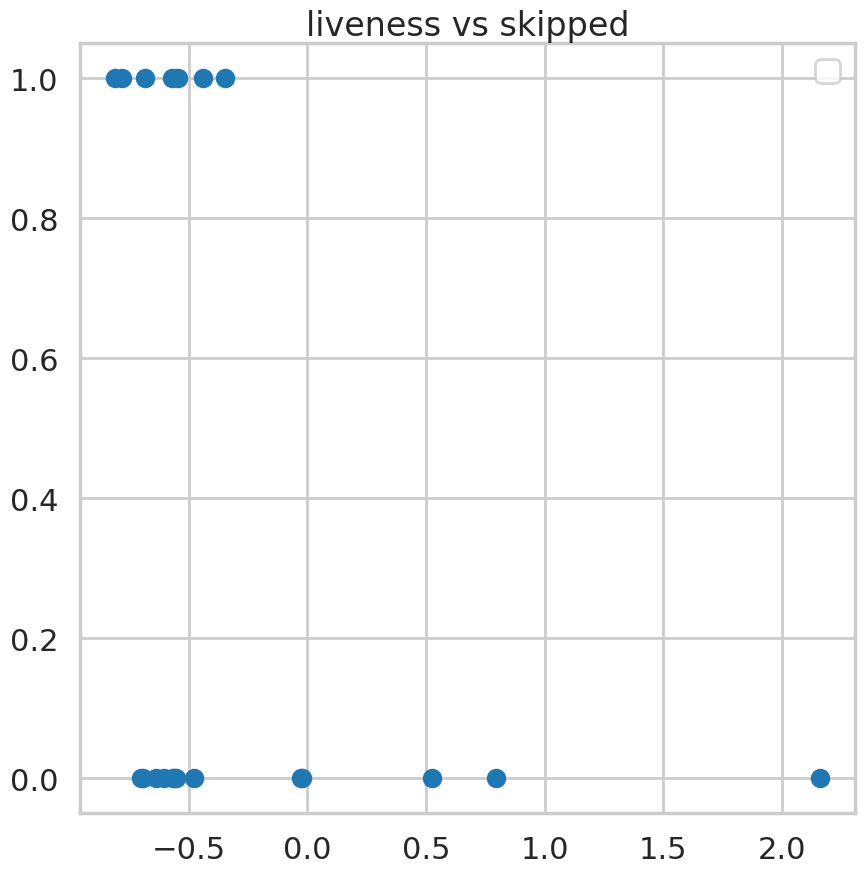

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


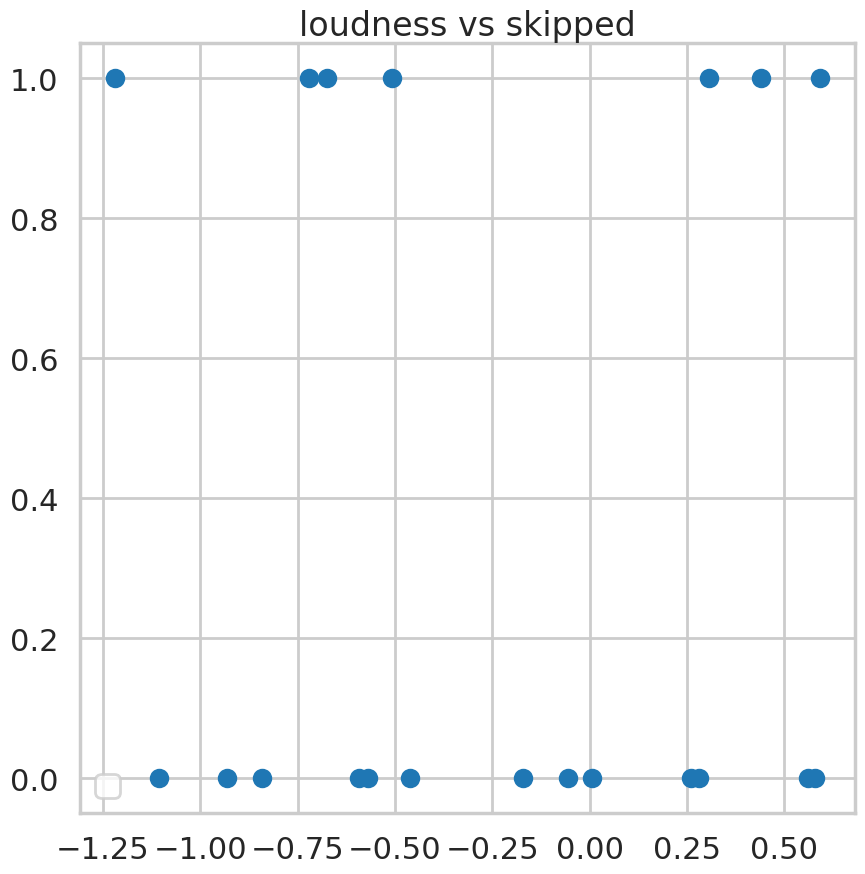

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


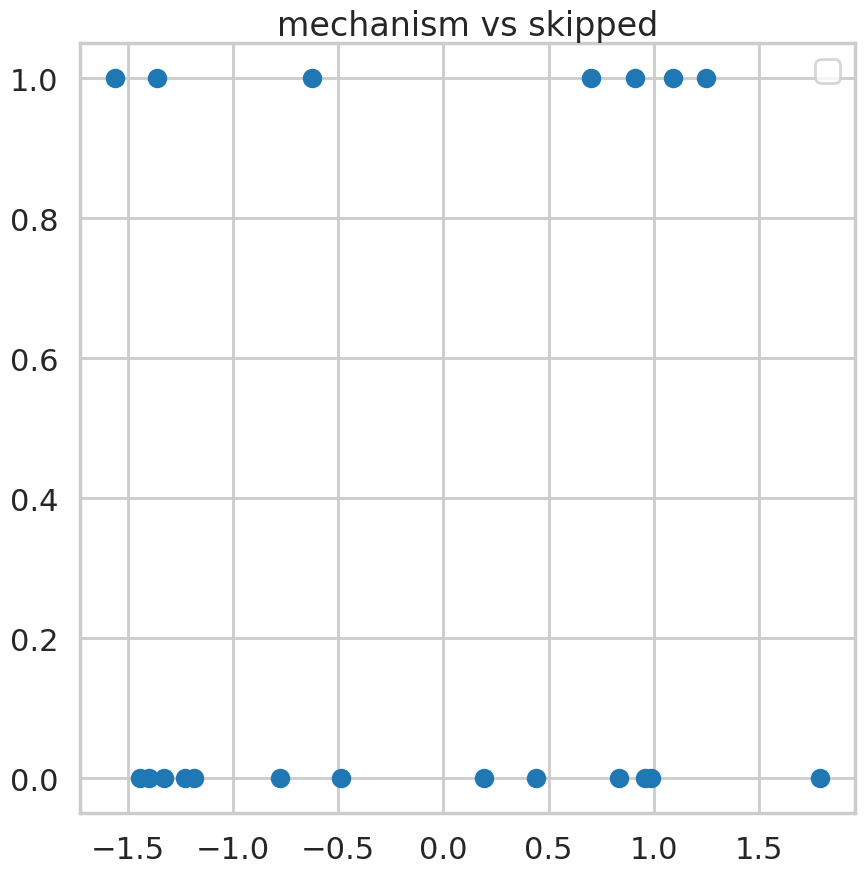

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


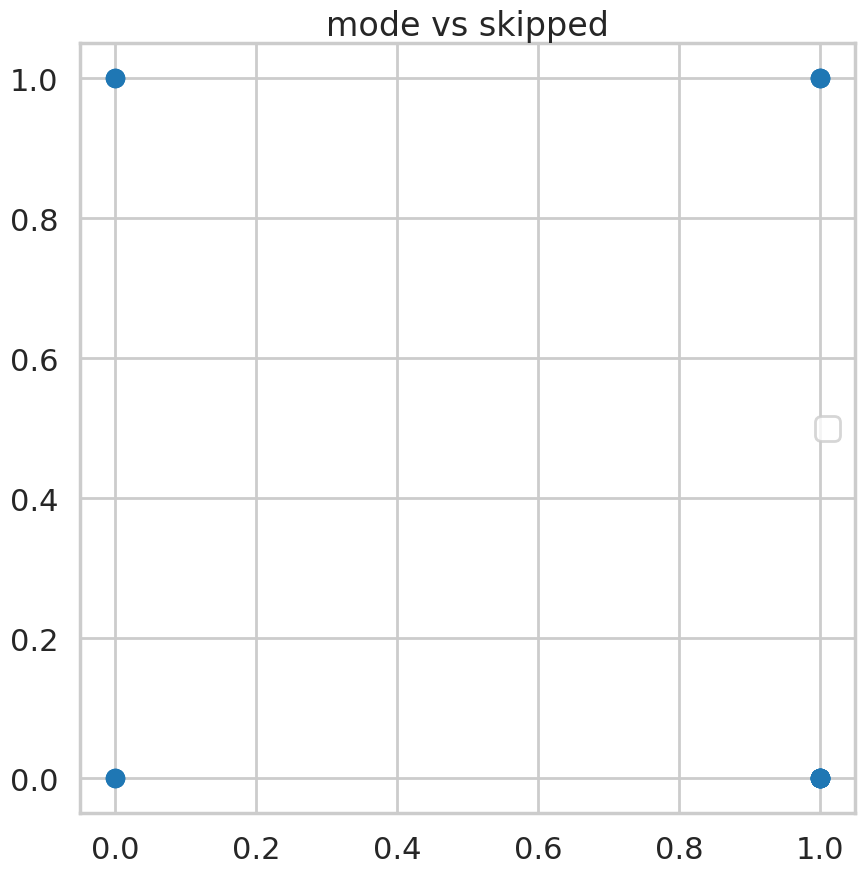

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


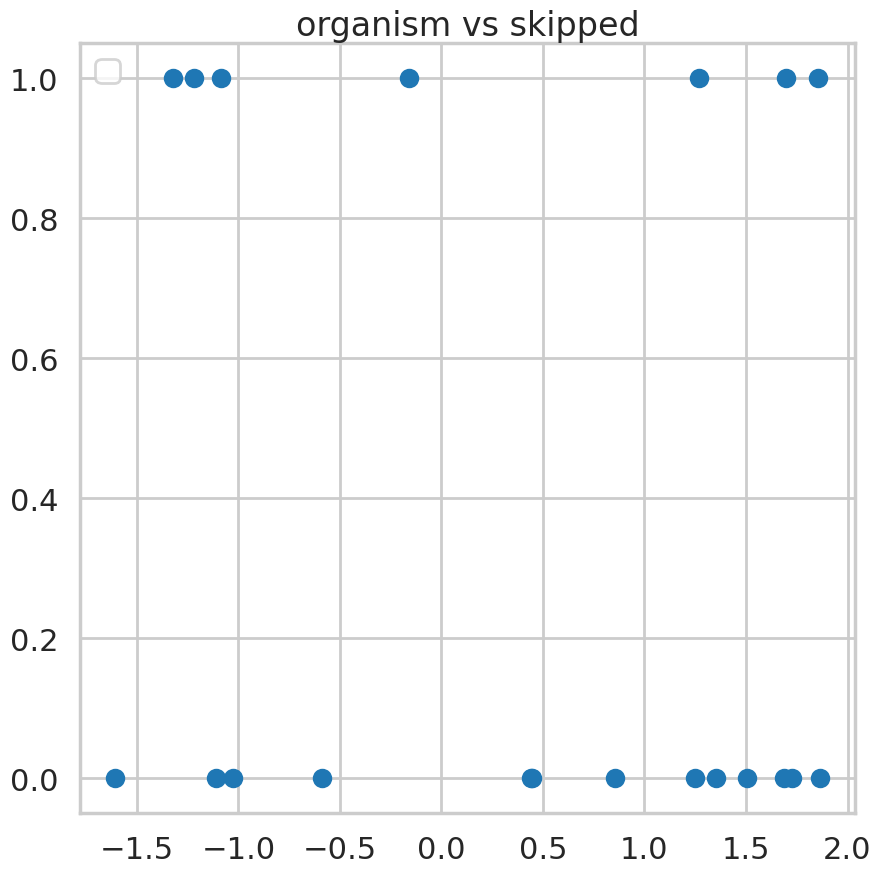

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


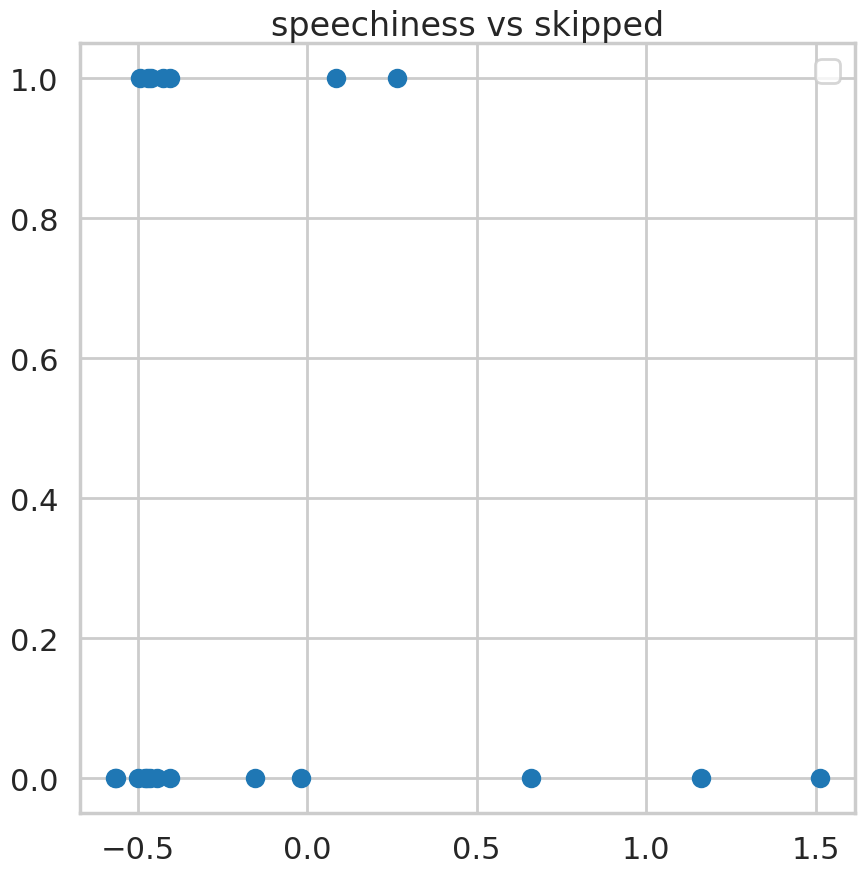

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


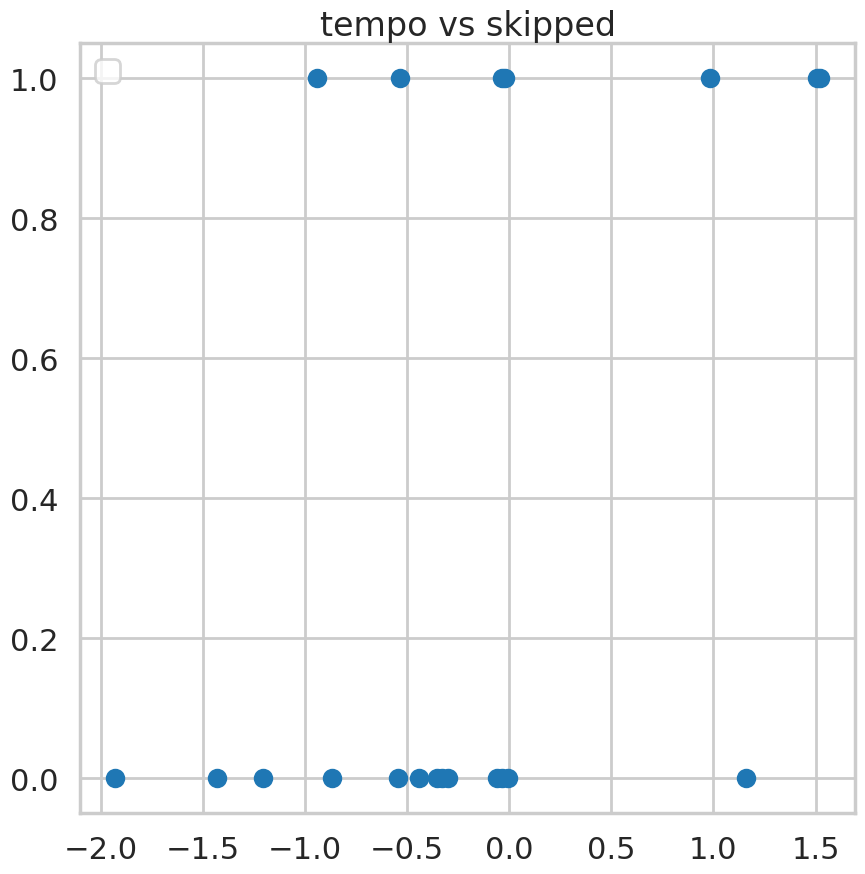

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


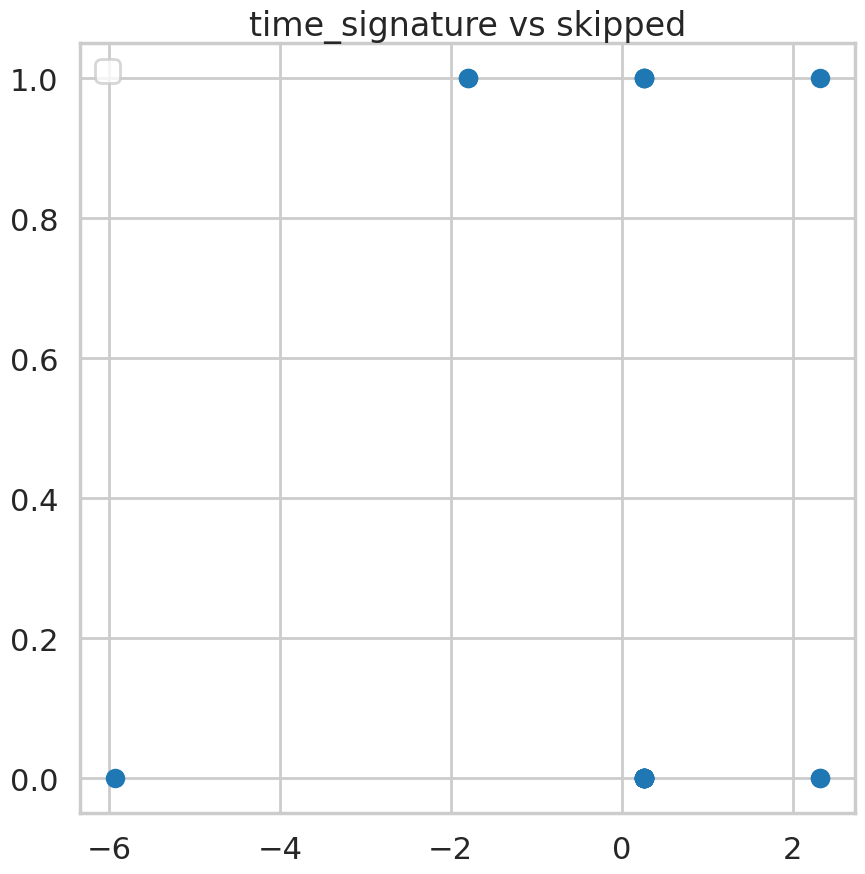

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


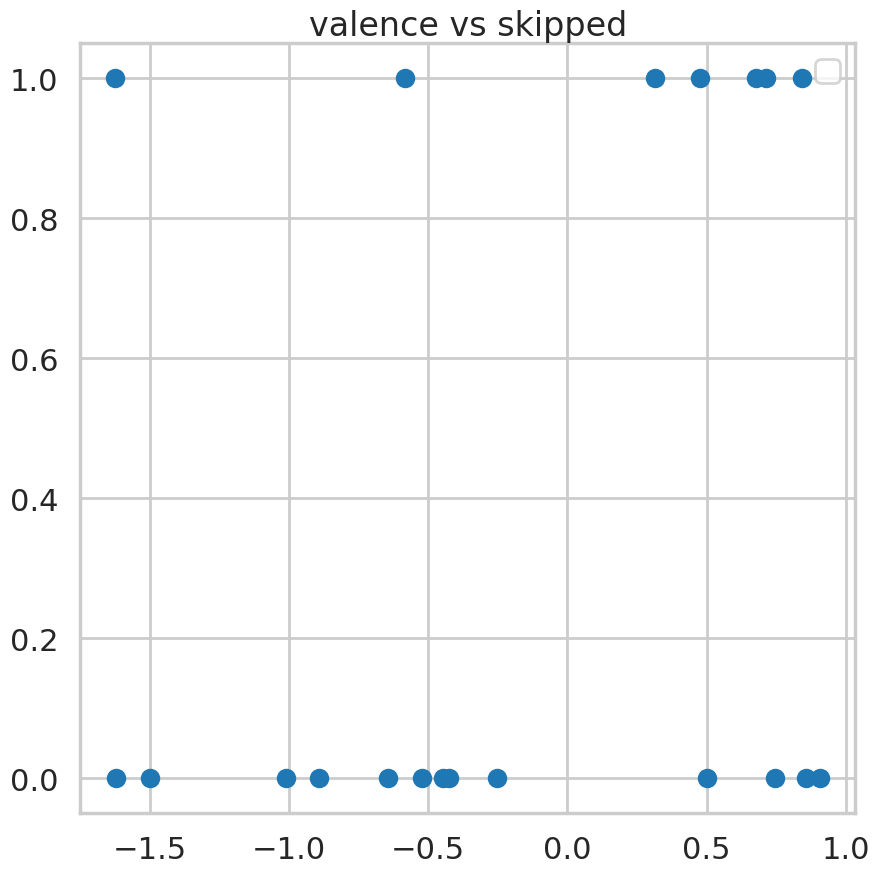

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


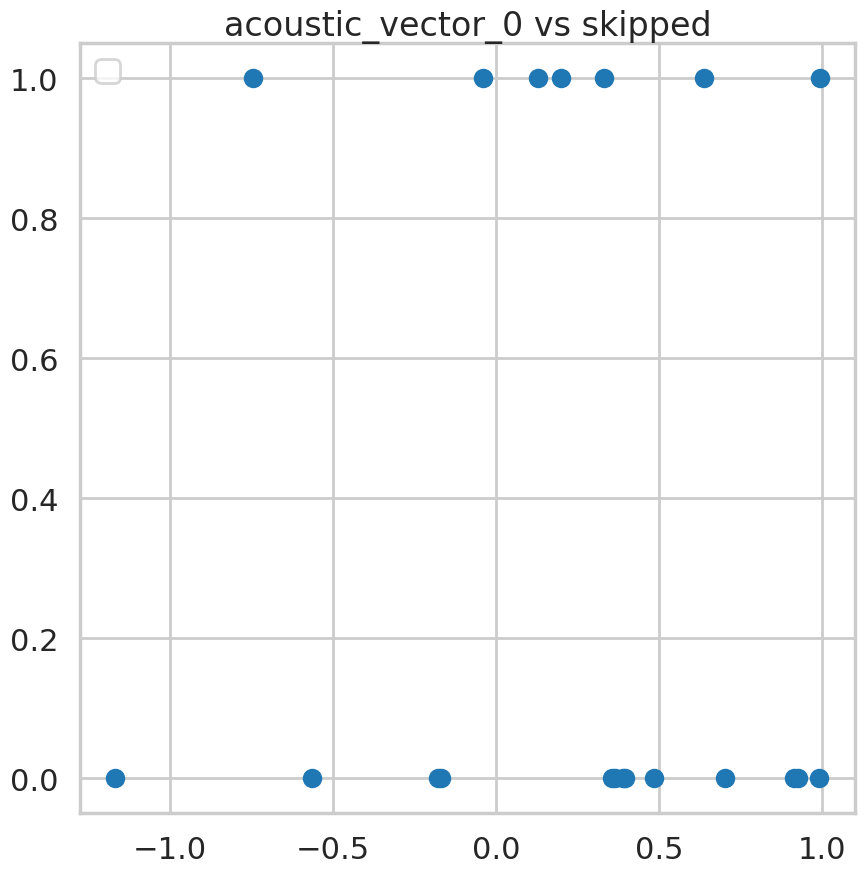

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


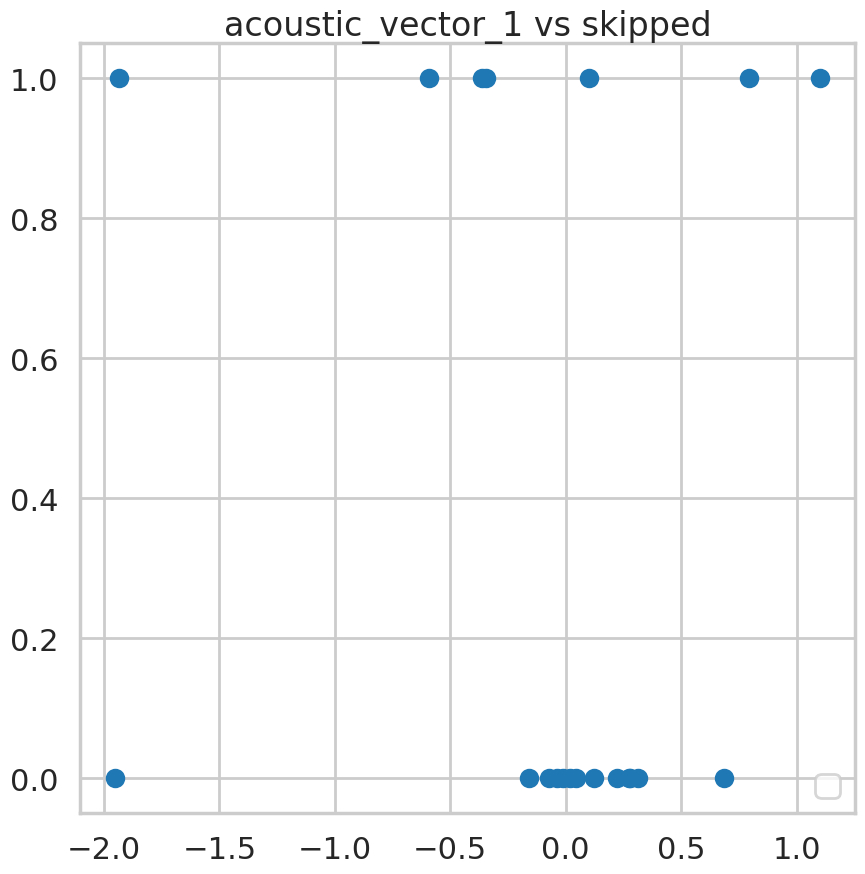

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


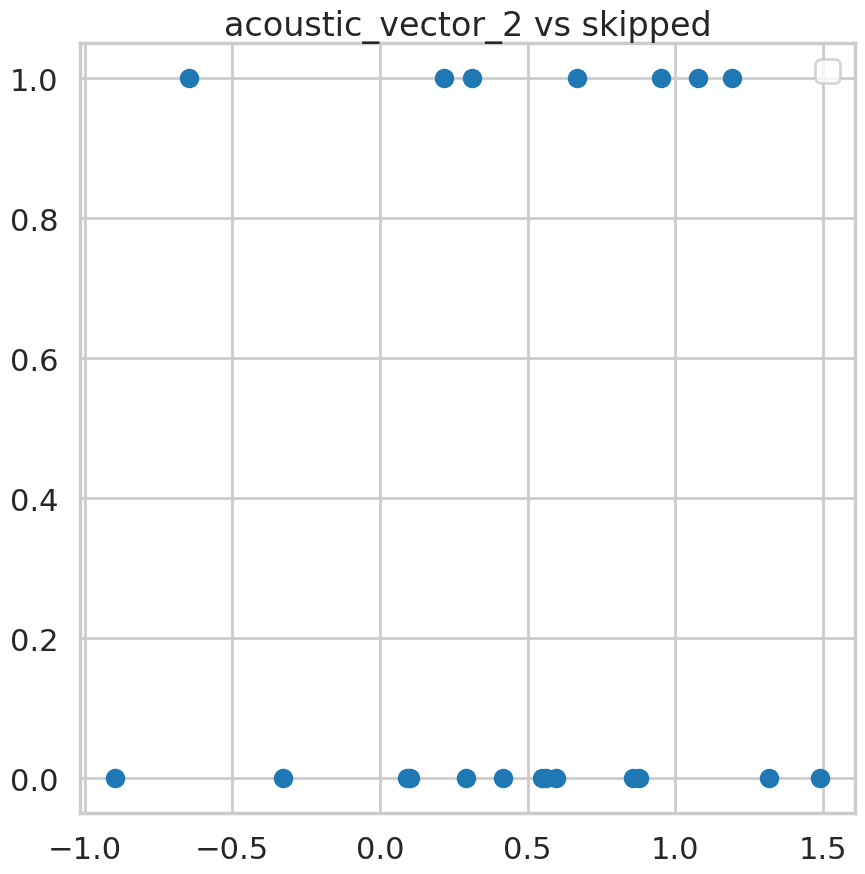

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


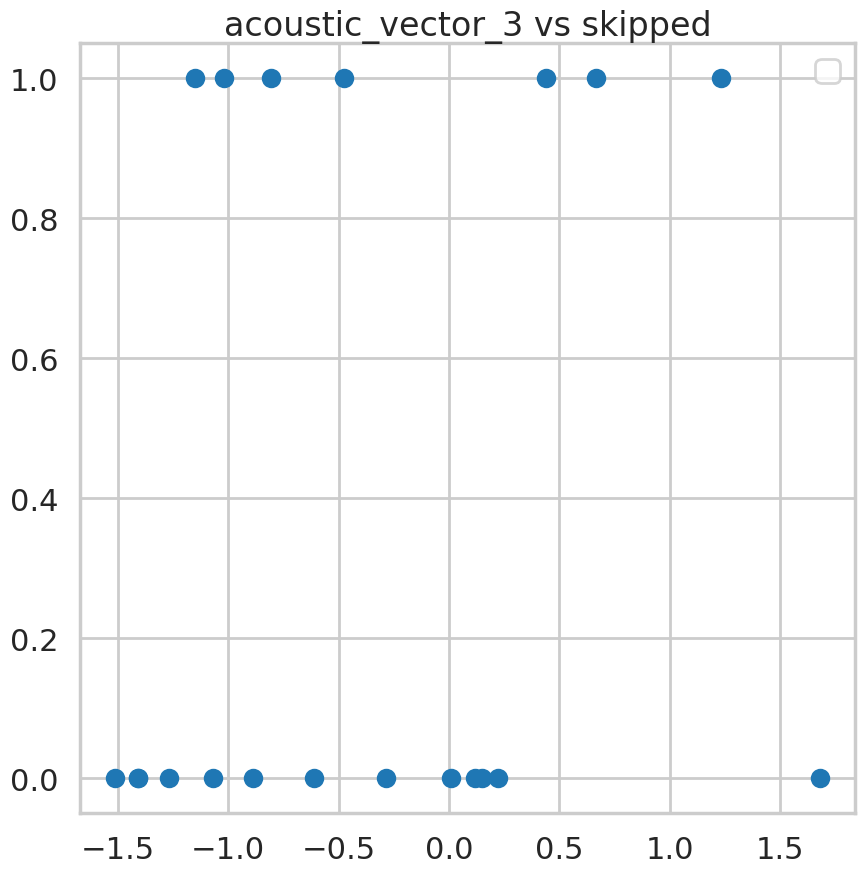

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


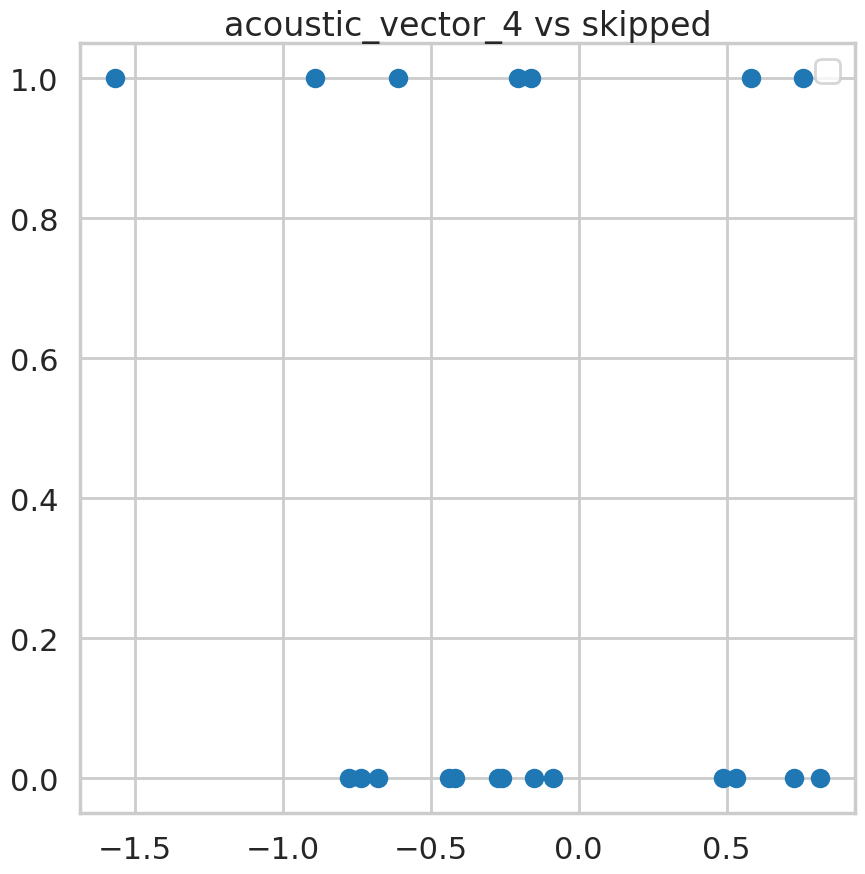

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


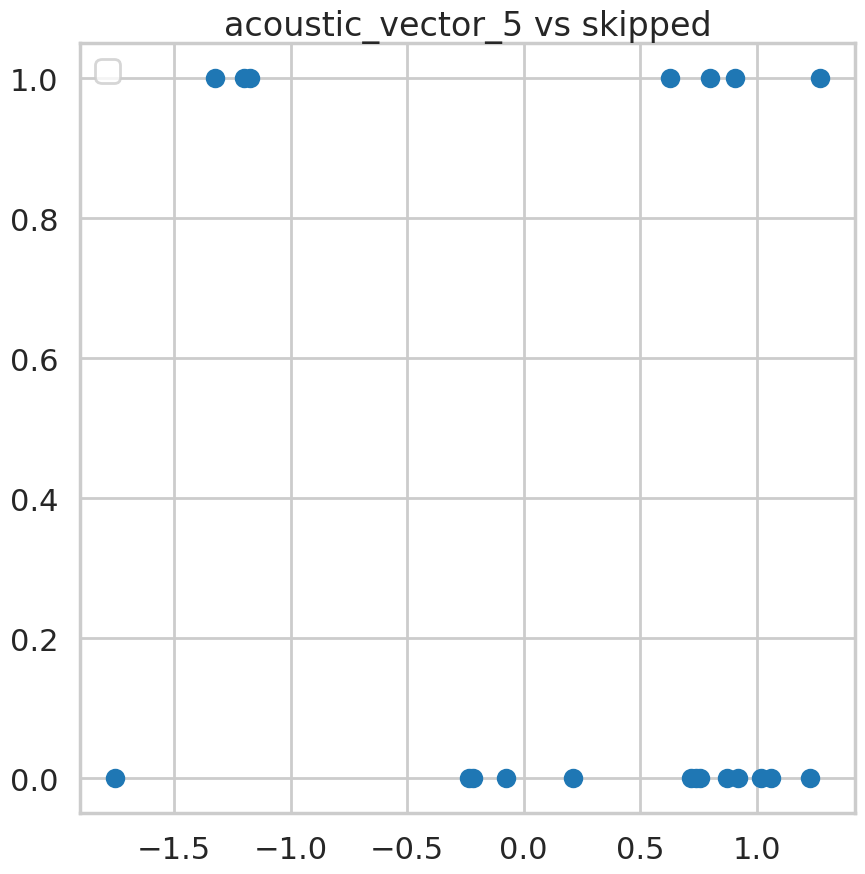

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


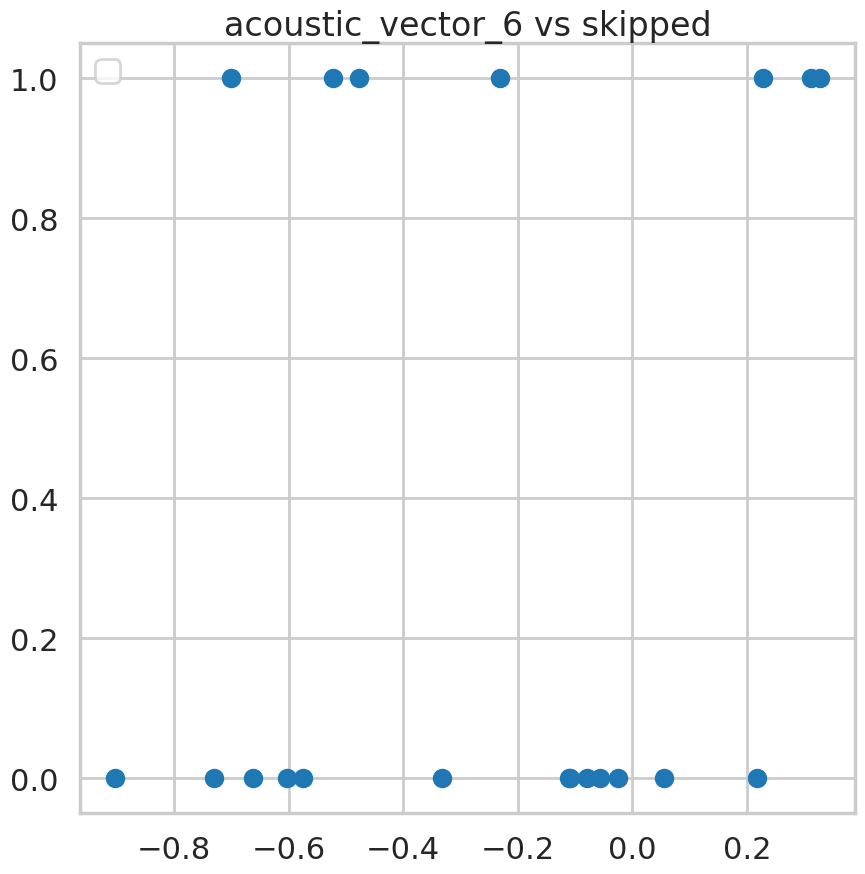

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


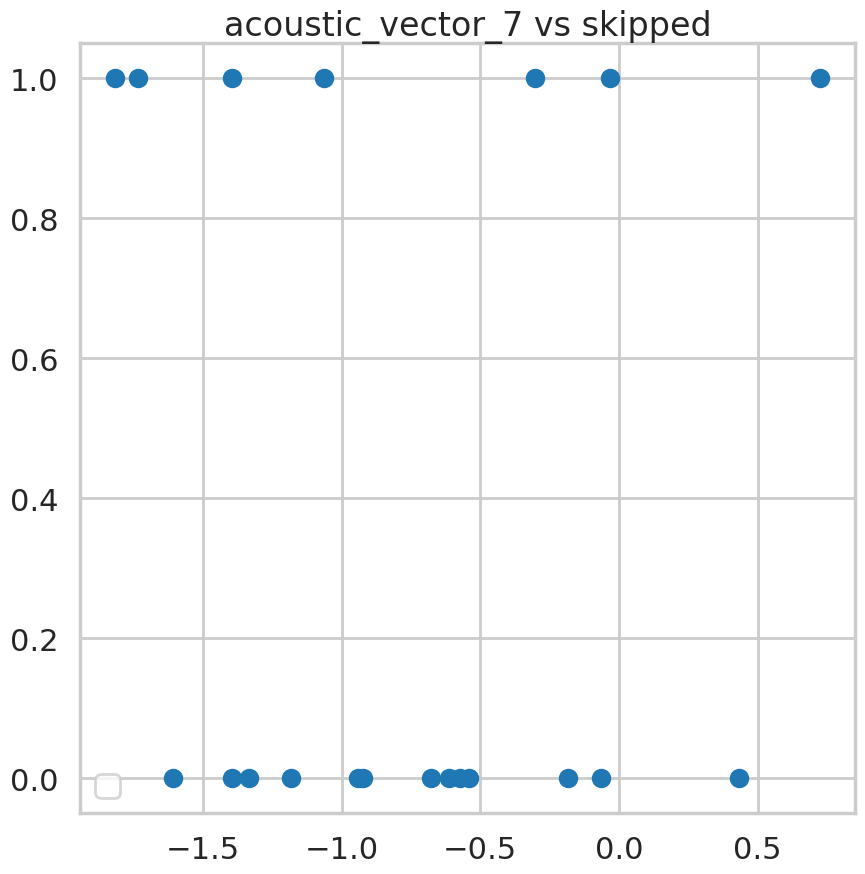

In [51]:
# make scatter plot of acoustic feature vs timestamp
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")
for feat in acoustic_feats:
    plt.figure(figsize=(10, 10))
    # plt.plot((labels[idx_list,:]), feats[idx_list,:,42+acoustic_feats_to_idx["liveness"]])
    # number of songs skipped vs liveness
    plt.title(f"{feat} vs skipped")
    plt.scatter(feats[idx_list[0],:,42+acoustic_feats_to_idx[feat]], (labels[[0],:]))
    plt.legend()
    plt.show()

